In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import main
import random
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
from tqdm import tqdm
from dataraw_sampling import decode_key_idx, encode_key_idx, decode_query_idx_to_key_properties, check_q1q2k_match, queryidx_to_querypair, decode_key_idx

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


In [2]:
def find_eulcidean(v, Wv):
    # (b, ), similarity = negative distance
    return - np.sum((v.reshape(1, -1) - Wv)**2, axis=-1)**(1/2)

def find_cos(v, Wv):
    dot_products = np.dot(Wv, v) # shape v,1
    l2norm_products = np.multiply(np.linalg.norm(Wv, axis=1),np.linalg.norm(v)) #shape v,1
    cos_sim = np.divide(dot_products,l2norm_products)
    return cos_sim

def find_dotproduct(v, Wv):
    # (b,)
    print('hit')
    return np.dot(Wv, v)

def find_nn(v, Wv, similarity_fn, k=None):
    """Find nearest neighbors of a given word, by cosine similarity.
    
    Returns two parallel lists: indices of nearest neighbors, and 
    their cosine similarities. Both lists are in descending order, 
    and inclusive: so nns[0] should be the index of the input word, 
    nns[1] should be the index of the first nearest neighbor, and so on.
    
    You may find the following numpy functions useful:
      np.linalg.norm : take the l2-norm of a vector or matrix
      np.dot : dot product or matrix multiplication
      np.argsort : get indices sorted by element value,
        so np.argsort(numbers)[-5:] will return the top five elements
    
    Args:
      v: (d-dimensional vector) word vector of interest
      Wv: (V x d matrix) word embeddings
      k: (int) number of neighbors to return
    
    Returns (nns, ds), where:
      nns: (k-dimensional vector of int), row indices of nearest neighbors, 
        which may include the given word.
      similarities: (k-dimensional vector of float), cosine similarity of each 
        neighbor in nns.
    """
    if k is None:
        k = Wv.shape[0]
    sim = similarity_fn(v, Wv)
    nns = np.argsort(sim)[-k:][::-1]
    similarities = np.take(sim, nns)
    return nns, similarities

def analogy(vA, vB, vC, Wv, k, similarity_fn):
    """Compute a linear analogy in vector space, as described in the async.
    Find the vector(s) that best answer "A is to B as C is to ___", returning 
    the top k candidates by cosine similarity.
    
    Args:
      vA: (d-dimensional vector) vector for word A
      vB: (d-dimensional vector) vector for word B
      vC: (d-dimensional vector) vector for word C
      Wv: (V x d matrix) word embeddings
      k: (int) number of neighbors to return
    Returns (nns, ds), where:
      nns: (k-dimensional vector of int), row indices of the top candidate 
        words.
      similarities: (k-dimensional vector of float), cosine similarity of each 
        of the top candidate words.
    """
    A_to_B = vB - vA
    vD = vC + A_to_B
    return find_nn(vD, Wv, similarity_fn, k)
    
    
def construct_filter(count_table, hparams, num_attr_shared_in_query, num_attr_hit_by_key=None):
    '''compute filters'''
    keep_queries = []
    keep_querykeys = np.zeros(count_table.shape)
    for i in range((hparams['query_support_size'])):
        card1, card2 = queryidx_to_querypair(hparams['num_attributes'], hparams['num_attr_vals'], i)
        if np.sum(card1 == card2) == num_attr_shared_in_query:
            keep_queries.append(True)
            for j in range(hparams['key_support_size']):
                num_matches = check_q1q2k_match(hparams['num_attributes'], hparams['num_attr_vals'], card1, card2, j)
                if num_matches == num_attr_hit_by_key:
                    keep_querykeys[j,i] = 1.0
        else:
            keep_queries.append(False)

    return keep_queries, keep_querykeys

In [3]:
# arguments
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.data_path = '../Raw_Datasets/3Attr-4Vals-2hat23Train-2hat12Val.json'
args.config_path = 'config.json'
args.mode = 'train'
args.generate_full_matrix = True

In [4]:
game_data = main.load_data(args.data_path)
main.validate_data(game_data)
hparams = main.load_hparams(args, game_data)

---------data----------
num_attributes : 3
num_attr_vals : 4
key_support_size : 65
query_support_size : 4096
train_datapoints length : 8388608
val_datapoints length : 4096
sparsity_estimate : 0.17980795755722673
-----------------------
----------hparams----------
seed : 42
batch_size : 512
max_epochs : 100
d_model : 4
embed_dropout : 0.0
model : contrastive
embedding_by_property : False
encoder : lookup
decoder : lookup
d_ff : 1024
num_heads : 1
N_enc : 2
N_dec : 2
attn_wt_tying_scheme : untie_QKVO_zero_O
attn_wt_dropout : 0.0
heads_dropout : 0.0
pff_dropout : 0.0
representation_pos : 0
dotproduct_bottleneck : True
normalize_dotproduct : True
contrastive_use_infoNCE : True
loss_temperature_const : 1.0
loss_smoothing_const : 0.1
nonlinear_classifier_scale_down_factor : [2, 1]
adam_lr : 0.001
adam_beta1 : 0.9
adam_beta2 : 0.999
adam_epsilon : 1e-08
adam_weight_decay : 0
sgd_lr : 0.001
sgd_momentum : 0
scheduled_adam_beta1 : 0.9
scheduled_adam_beta2 : 0.98
scheduled_adam_epsilon : 1e-09
s

In [5]:
gt = main.gen_full_matrix(hparams)
xy = gt['xy']
xy_div_xyind = gt['xy_div_xyind']
count_table = gt['count_table']

Generating Full Matrix
Generated 65 unqiue cards
Generated 4096 cardpairs
-- 2368 cardpairs with shared concept
-- 1728 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 1728), (0, 1728), (2, 576), (3, 64)]
Total number of matches =  47872
Number of matches per key concept hit =  [(1, 43200), (2, 2880), (0, 1728), (3, 64)]
{'shape': (65, 4096), 'size': 266240, 'sparsity': 0.1798076923076923, 'xy_rank': 65, 'xy_div_xyind_rank': 65}


In [28]:
np.linalg.matrix_rank(xy)

65

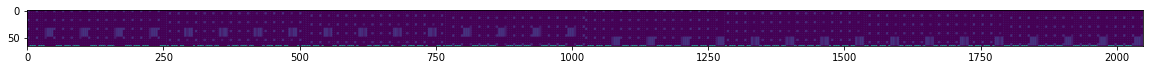

In [107]:
plt.figure(figsize=(20, 50))
plt.imshow(xy_div_xyind[:, 2048:])

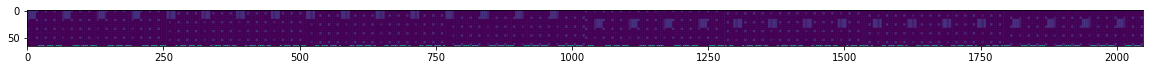

In [108]:
plt.figure(figsize=(20, 50))
plt.imshow(xy_div_xyind[:, :2048])

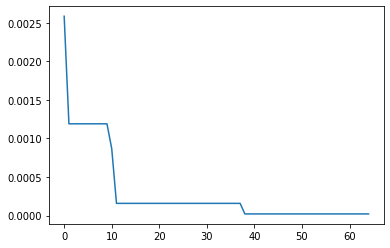

In [110]:
u,s,vh = np.linalg.svd(xy, full_matrices=False)
plt.plot(s)

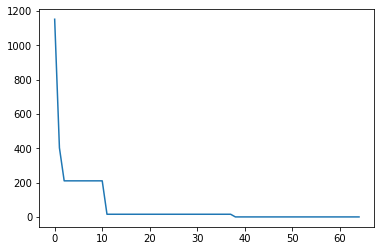

In [111]:
u,s,vh = np.linalg.svd(xy_div_xyind, full_matrices=False)
plt.plot(s)

In [106]:
s

array([1151.62133694,  403.87518426,  211.65034456,  211.65034456,
        211.65034456,  211.65034456,  211.65034456,  211.65034456,
        211.65034456,  211.65034456,  211.65034456,   17.28847838,
         17.28847838,   17.28847838,   17.28847838,   17.28847838,
         17.28847838,   17.28847838,   17.28847838,   17.28847838,
         17.28847838,   17.28847838,   17.28847838,   17.28847838,
         17.28847838,   17.28847838,   17.28847838,   17.28847838,
         17.28847838,   17.28847838,   17.28847838,   17.28847838,
         17.28847838,   17.28847838,   17.28847838,   17.28847838,
         17.28847838,   17.28847838,    1.79450463,    1.79450463,
          1.79450463,    1.79450463,    1.79450463,    1.79450463,
          1.79450463,    1.79450463,    1.79450463,    1.79450463,
          1.79450463,    1.79450463,    1.79450463,    1.79450463,
          1.79450463,    1.79450463,    1.79450463,    1.79450463,
          1.79450463,    1.79450463,    1.79450463,    1.79450

In [9]:
d_model = 65
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr

# 65
# u_repr.shape (65, 65)
# vh_repr.shape (65, 4096)
# errors: 0
# successes: 266240


# 37
# u_repr.shape (65, 37)
# vh_repr.shape (37, 4096)
# errors: 8958
# successes: 257282


# 10
# u_repr.shape (65, 37)
# vh_repr.shape (37, 4096)
# errors: 8958
# successes: 257282

u_repr.shape (65, 65)
vh_repr.shape (65, 4096)
errors: 0
successes: 266240


In [26]:
d_model = 37
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr

u_repr.shape (65, 37)
vh_repr.shape (37, 4096)
errors: 8958
successes: 257282


In [85]:
d_model = 1
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr

u_repr.shape (65, 1)
vh_repr.shape (1, 4096)
errors: 48512
successes: 217728


In [86]:
# closest key for each key
for i in range(game_data['key_support_size']):
    print('key:' ,decode_key_idx(game_data['num_attributes'], game_data['num_attr_vals'], i))
    print(('NNs:\n'))
    nns, distances = find_nn(v=key_repr[i], Wv=key_repr, similarity_fn=find_cos)
    for nni, dist in zip(nns, distances):
        print(decode_key_idx(game_data['num_attributes'], game_data['num_attr_vals'], nni.item()), dist)
    print('---------------------------')

key: [0 0 0]
NNs:

[0 1 1] nan
[] 1.0
[1 2 0] 1.0
[2 1 0] 1.0
[2 0 3] 1.0
[2 0 1] 1.0
[3 3 3] 1.0
[1 3 3] 1.0
[1 3 1] 1.0
[1 3 0] 1.0
[1 2 3] 1.0
[1 2 1] 1.0
[1 1 3] 1.0
[2 1 3] 1.0
[1 1 1] 1.0
[1 1 0] 1.0
[1 0 3] 1.0
[1 0 1] 1.0
[1 0 0] 1.0
[0 3 0] 1.0
[0 2 0] 1.0
[0 0 3] 1.0
[0 0 1] 1.0
[2 1 1] 1.0
[2 0 0] 1.0
[2 2 0] 1.0
[3 0 0] 1.0
[3 3 1] 1.0
[3 3 0] 1.0
[3 2 3] 1.0
[3 2 1] 1.0
[3 2 0] 1.0
[3 1 1] 1.0
[3 1 0] 1.0
[3 0 3] 1.0
[3 0 1] 1.0
[3 1 3] 1.0
[2 3 3] 1.0
[2 3 1] 1.0
[2 2 1] 1.0
[2 2 3] 1.0
[0 0 0] 1.0
[1 1 2] -1.0
[0 2 2] -1.0
[3 3 2] -1.0
[0 0 2] -1.0
[3 0 2] -1.0
[0 1 0] -1.0
[2 2 2] -1.0
[0 1 2] -1.0
[0 1 3] -1.0
[1 3 2] -1.0
[0 2 1] -1.0
[0 2 3] -1.0
[2 3 2] -1.0
[3 2 2] -1.0
[1 2 2] -1.0
[0 3 2] -1.0
[0 3 3] -1.0
[2 0 2] -1.0
[2 3 0] -1.0
[1 0 2] -1.0
[2 1 2] -1.0
[3 1 2] -1.0
[0 3 1] -1.0
---------------------------
key: [0 0 1]
NNs:

[0 1 1] nan
[] 1.0
[1 2 0] 1.0
[2 1 0] 1.0
[2 0 3] 1.0
[2 0 1] 1.0
[3 3 3] 1.0
[1 3 3] 1.0
[1 3 1] 1.0
[1 3 0] 1.0
[1 2 3] 1.0
[1 2 1] 1

[0 2 3] 1.0
[3 0 2] 1.0
[0 2 1] 1.0
[0 1 3] 1.0
[3 1 2] 1.0
[0 1 2] 1.0
[0 1 0] 1.0
[3 2 2] 1.0
[1 3 2] 1.0
[0 0 2] 1.0
[3 3 2] 1.0
[1 0 2] 1.0
[1 1 0] -1.0
[1 1 3] -1.0
[1 1 1] -1.0
[1 2 0] -1.0
[] -1.0
[1 0 3] -1.0
[1 0 1] -1.0
[1 0 0] -1.0
[0 3 0] -1.0
[0 2 0] -1.0
[0 0 3] -1.0
[0 0 1] -1.0
[1 2 1] -1.0
[2 0 0] -1.0
[1 2 3] -1.0
[2 3 3] -1.0
[3 3 1] -1.0
[3 3 0] -1.0
[3 2 3] -1.0
[3 2 1] -1.0
[3 2 0] -1.0
[3 1 3] -1.0
[3 1 1] -1.0
[3 1 0] -1.0
[3 0 3] -1.0
[3 0 1] -1.0
[3 0 0] -1.0
[2 3 1] -1.0
[1 3 0] -1.0
[2 2 3] -1.0
[2 2 1] -1.0
[2 2 0] -1.0
[2 1 3] -1.0
[2 1 1] -1.0
[2 1 0] -1.0
[2 0 3] -1.0
[2 0 1] -1.0
[3 3 3] -1.0
[1 3 3] -1.0
[1 3 1] -1.0
[0 0 0] -1.0
---------------------------
key: [0 3 2]
NNs:

[0 1 1] nan
[2 3 2] 1.0
[0 2 2] 1.0
[2 1 2] 1.0
[2 0 2] 1.0
[0 3 3] 1.0
[2 2 2] 1.0
[0 3 2] 1.0
[2 3 0] 1.0
[0 3 1] 1.0
[1 2 2] 1.0
[1 1 2] 1.0
[0 2 3] 1.0
[3 0 2] 1.0
[0 2 1] 1.0
[0 1 3] 1.0
[3 1 2] 1.0
[0 1 2] 1.0
[0 1 0] 1.0
[3 2 2] 1.0
[1 3 2] 1.0
[0 0 2] 1.0
[3 3 2] 1.0
[1 0 

<ipython-input-2-16c51cc80d5f>:8: RuntimeWarning: invalid value encountered in true_divide
  cos_sim = np.divide(dot_products,l2norm_products)


 -1.0
[2 1 0] -1.0
[2 0 3] -1.0
[2 0 1] -1.0
[3 3 3] -1.0
[1 3 3] -1.0
[1 3 1] -1.0
[0 0 0] -1.0
---------------------------
key: [0 3 3]
NNs:

[0 1 1] nan
[2 3 2] 1.0
[0 2 2] 1.0
[2 1 2] 1.0
[2 0 2] 1.0
[0 3 3] 1.0
[2 2 2] 1.0
[0 3 2] 1.0
[2 3 0] 1.0
[0 3 1] 1.0
[1 2 2] 1.0
[1 1 2] 1.0
[0 2 3] 1.0
[3 0 2] 1.0
[0 2 1] 1.0
[0 1 3] 1.0
[3 1 2] 1.0
[0 1 2] 1.0
[0 1 0] 1.0
[3 2 2] 1.0
[1 3 2] 1.0
[0 0 2] 1.0
[3 3 2] 1.0
[1 0 2] 1.0
[1 1 0] -1.0
[1 1 3] -1.0
[1 1 1] -1.0
[1 2 0] -1.0
[] -1.0
[1 0 3] -1.0
[1 0 1] -1.0
[1 0 0] -1.0
[0 3 0] -1.0
[0 2 0] -1.0
[0 0 3] -1.0
[0 0 1] -1.0
[1 2 1] -1.0
[2 0 0] -1.0
[1 2 3] -1.0
[2 3 3] -1.0
[3 3 1] -1.0
[3 3 0] -1.0
[3 2 3] -1.0
[3 2 1] -1.0
[3 2 0] -1.0
[3 1 3] -1.0
[3 1 1] -1.0
[3 1 0] -1.0
[3 0 3] -1.0
[3 0 1] -1.0
[3 0 0] -1.0
[2 3 1] -1.0
[1 3 0] -1.0
[2 2 3] -1.0
[2 2 1] -1.0
[2 2 0] -1.0
[2 1 3] -1.0
[2 1 1] -1.0
[2 1 0] -1.0
[2 0 3] -1.0
[2 0 1] -1.0
[3 3 3] -1.0
[1 3 3] -1.0
[1 3 1] -1.0
[0 0 0] -1.0
---------------------------
key: [1 0 0]

[2 3 0] -1.0
[1 0 2] -1.0
[2 1 2] -1.0
[3 1 2] -1.0
[0 3 1] -1.0
---------------------------
key: [1 3 1]
NNs:

[0 1 1] nan
[] 1.0
[1 2 0] 1.0
[2 1 0] 1.0
[2 0 3] 1.0
[2 0 1] 1.0
[3 3 3] 1.0
[1 3 3] 1.0
[1 3 1] 1.0
[1 3 0] 1.0
[1 2 3] 1.0
[1 2 1] 1.0
[1 1 3] 1.0
[2 1 3] 1.0
[1 1 1] 1.0
[1 1 0] 1.0
[1 0 3] 1.0
[1 0 1] 1.0
[1 0 0] 1.0
[0 3 0] 1.0
[0 2 0] 1.0
[0 0 3] 1.0
[0 0 1] 1.0
[2 1 1] 1.0
[2 0 0] 1.0
[2 2 0] 1.0
[3 0 0] 1.0
[3 3 1] 1.0
[3 3 0] 1.0
[3 2 3] 1.0
[3 2 1] 1.0
[3 2 0] 1.0
[3 1 1] 1.0
[3 1 0] 1.0
[3 0 3] 1.0
[3 0 1] 1.0
[3 1 3] 1.0
[2 3 3] 1.0
[2 3 1] 1.0
[2 2 1] 1.0
[2 2 3] 1.0
[0 0 0] 1.0
[1 1 2] -1.0
[0 2 2] -1.0
[3 3 2] -1.0
[0 0 2] -1.0
[3 0 2] -1.0
[0 1 0] -1.0
[2 2 2] -1.0
[0 1 2] -1.0
[0 1 3] -1.0
[1 3 2] -1.0
[0 2 1] -1.0
[0 2 3] -1.0
[2 3 2] -1.0
[3 2 2] -1.0
[1 2 2] -1.0
[0 3 2] -1.0
[0 3 3] -1.0
[2 0 2] -1.0
[2 3 0] -1.0
[1 0 2] -1.0
[2 1 2] -1.0
[3 1 2] -1.0
[0 3 1] -1.0
---------------------------
key: [1 3 2]
NNs:

[0 1 1] nan
[2 3 2] 1.0
[0 2 2] 1.0
[2 1 2]

[3 2 3] 1.0
[3 2 1] 1.0
[3 2 0] 1.0
[3 1 1] 1.0
[3 1 0] 1.0
[3 0 3] 1.0
[3 0 1] 1.0
[3 1 3] 1.0
[2 3 3] 1.0
[2 3 1] 1.0
[2 2 1] 1.0
[2 2 3] 1.0
[0 0 0] 1.0
[1 1 2] -1.0
[0 2 2] -1.0
[3 3 2] -1.0
[0 0 2] -1.0
[3 0 2] -1.0
[0 1 0] -1.0
[2 2 2] -1.0
[0 1 2] -1.0
[0 1 3] -1.0
[1 3 2] -1.0
[0 2 1] -1.0
[0 2 3] -1.0
[2 3 2] -1.0
[3 2 2] -1.0
[1 2 2] -1.0
[0 3 2] -1.0
[0 3 3] -1.0
[2 0 2] -1.0
[2 3 0] -1.0
[1 0 2] -1.0
[2 1 2] -1.0
[3 1 2] -1.0
[0 3 1] -1.0
---------------------------
key: [2 3 0]
NNs:

[0 1 1] nan
[2 3 2] 1.0
[0 2 2] 1.0
[2 1 2] 1.0
[2 0 2] 1.0
[0 3 3] 1.0
[2 2 2] 1.0
[0 3 2] 1.0
[2 3 0] 1.0
[0 3 1] 1.0
[1 2 2] 1.0
[1 1 2] 1.0
[0 2 3] 1.0
[3 0 2] 1.0
[0 2 1] 1.0
[0 1 3] 1.0
[3 1 2] 1.0
[0 1 2] 1.0
[0 1 0] 1.0
[3 2 2] 1.0
[1 3 2] 1.0
[0 0 2] 1.0
[3 3 2] 1.0
[1 0 2] 1.0
[1 1 0] -1.0
[1 1 3] -1.0
[1 1 1] -1.0
[1 2 0] -1.0
[] -1.0
[1 0 3] -1.0
[1 0 1] -1.0
[1 0 0] -1.0
[0 3 0] -1.0
[0 2 0] -1.0
[0 0 3] -1.0
[0 0 1] -1.0
[1 2 1] -1.0
[2 0 0] -1.0
[1 2 3] -1.0
[2 3 3] -1.0
[3 3 1]

[1 0 1] -1.0
[1 0 0] -1.0
[0 3 0] -1.0
[0 2 0] -1.0
[0 0 3] -1.0
[0 0 1] -1.0
[1 2 1] -1.0
[2 0 0] -1.0
[1 2 3] -1.0
[2 3 3] -1.0
[3 3 1] -1.0
[3 3 0] -1.0
[3 2 3] -1.0
[3 2 1] -1.0
[3 2 0] -1.0
[3 1 3] -1.0
[3 1 1] -1.0
[3 1 0] -1.0
[3 0 3] -1.0
[3 0 1] -1.0
[3 0 0] -1.0
[2 3 1] -1.0
[1 3 0] -1.0
[2 2 3] -1.0
[2 2 1] -1.0
[2 2 0] -1.0
[2 1 3] -1.0
[2 1 1] -1.0
[2 1 0] -1.0
[2 0 3] -1.0
[2 0 1] -1.0
[3 3 3] -1.0
[1 3 3] -1.0
[1 3 1] -1.0
[0 0 0] -1.0
---------------------------
key: [3 2 3]
NNs:

[0 1 1] nan
[] 1.0
[1 2 0] 1.0
[2 1 0] 1.0
[2 0 3] 1.0
[2 0 1] 1.0
[3 3 3] 1.0
[1 3 3] 1.0
[1 3 1] 1.0
[1 3 0] 1.0
[1 2 3] 1.0
[1 2 1] 1.0
[1 1 3] 1.0
[2 1 3] 1.0
[1 1 1] 1.0
[1 1 0] 1.0
[1 0 3] 1.0
[1 0 1] 1.0
[1 0 0] 1.0
[0 3 0] 1.0
[0 2 0] 1.0
[0 0 3] 1.0
[0 0 1] 1.0
[2 1 1] 1.0
[2 0 0] 1.0
[2 2 0] 1.0
[3 0 0] 1.0
[3 3 1] 1.0
[3 3 0] 1.0
[3 2 3] 1.0
[3 2 1] 1.0
[3 2 0] 1.0
[3 1 1] 1.0
[3 1 0] 1.0
[3 0 3] 1.0
[3 0 1] 1.0
[3 1 3] 1.0
[2 3 3] 1.0
[2 3 1] 1.0
[2 2 1] 1.0
[2 2 3] 1.0
[0 0 0] 1.0

In [87]:
# closest query for each key
found_idxs = []

for i in tqdm(range(game_data['key_support_size'])):
    key_prop = tuple(decode_key_idx(game_data['num_attributes'], game_data['num_attr_vals'], i))
    print('key:' , key_prop)
    print(('NNs:\n'))
    nns, distances = find_nn(v=key_repr[i], Wv=query_repr.T, similarity_fn=find_dotproduct, k=None)
    for j, (nni, dist) in enumerate(zip(nns, distances)):
        query_prop = decode_query_idx_to_key_properties(game_data['num_attributes'], game_data['num_attr_vals'], nni.item())
        query_prop = (tuple(query_prop[0]),tuple(query_prop[1]))
        if tuple(set(query_prop)) == (key_prop,):
            found_idx = j
            found_qkdist = (key_prop, query_prop, dist)
#         print(f'{j} \t', query_prop, 
#               dist.item())
    print(found_idx)
    found_idxs.append((found_idx, found_qkdist))
    print('---------------------------')
    

  0%|          | 0/65 [00:00<?, ?it/s]

key: (0, 0, 0)
NNs:

hit
1731
---------------------------
key: (0, 0, 1)
NNs:

hit
4083
---------------------------
key: (0, 0, 2)
NNs:

hit


  6%|▌         | 4/65 [00:00<00:01, 33.86it/s]

10
---------------------------
key: (0, 0, 3)
NNs:

hit
1732
---------------------------
key: (0, 1, 0)
NNs:

hit
15
---------------------------
key: (0, 1, 1)
NNs:

hit
1050
---------------------------
key: (0, 1, 2)
NNs:

hit


 11%|█         | 7/65 [00:00<00:01, 32.59it/s]

22
---------------------------
key: (0, 1, 3)
NNs:

hit
2354
---------------------------
key: (0, 2, 0)
NNs:

hit
1745
---------------------------
key: (0, 2, 1)
NNs:

hit


 15%|█▌        | 10/65 [00:00<00:01, 28.51it/s]

2347
---------------------------
key: (0, 2, 2)
NNs:

hit
2345
---------------------------
key: (0, 2, 3)
NNs:

hit


 18%|█▊        | 12/65 [00:00<00:02, 24.99it/s]

5
---------------------------
key: (0, 3, 0)
NNs:

hit
4002
---------------------------
key: (0, 3, 1)
NNs:

hit


 22%|██▏       | 14/65 [00:00<00:02, 22.96it/s]

26
---------------------------
key: (0, 3, 2)
NNs:

hit
2355
---------------------------
key: (0, 3, 3)
NNs:

hit
20
---------------------------
key: (1, 0, 0)
NNs:

hit


 26%|██▌       | 17/65 [00:00<00:01, 24.28it/s]

1785
---------------------------
key: (1, 0, 1)
NNs:

hit
4074
---------------------------
key: (1, 0, 2)
NNs:

hit
16
---------------------------
key: (1, 0, 3)
NNs:

hit
1738
---------------------------
key: (1, 1, 0)
NNs:

hit


 32%|███▏      | 21/65 [00:00<00:01, 26.10it/s]

1754
---------------------------
key: (1, 1, 1)
NNs:

hit
1734
---------------------------
key: (1, 1, 2)
NNs:

hit
0
---------------------------
key: (1, 1, 3)
NNs:

hit


 37%|███▋      | 24/65 [00:00<00:01, 24.45it/s]

1756
---------------------------
key: (1, 2, 0)
NNs:

hit
4077
---------------------------
key: (1, 2, 1)
NNs:

hit
4087
---------------------------
key: (1, 2, 2)
NNs:

hit


 42%|████▏     | 27/65 [00:01<00:01, 22.77it/s]

2359
---------------------------
key: (1, 2, 3)
NNs:

hit


 46%|████▌     | 30/65 [00:01<00:01, 22.19it/s]

1755
---------------------------
key: (1, 3, 0)
NNs:

hit
1753
---------------------------
key: (1, 3, 1)
NNs:

hit
1780
---------------------------
key: (1, 3, 2)
NNs:

hit
2358
---------------------------
key: (1, 3, 3)
NNs:

hit
4091
---------------------------
key: (2, 0, 0)
NNs:

hit
1781
---------------------------
key: (2, 0, 1)
NNs:

hit


 52%|█████▏    | 34/65 [00:01<00:01, 24.54it/s]

1746
---------------------------
key: (2, 0, 2)
NNs:

hit
2356
---------------------------
key: (2, 0, 3)
NNs:

hit
4092
---------------------------
key: (2, 1, 0)
NNs:

hit
1730
---------------------------
key: (2, 1, 1)
NNs:

hit


 58%|█████▊    | 38/65 [00:01<00:01, 26.65it/s]

4082
---------------------------
key: (2, 1, 2)
NNs:

hit
2362
---------------------------
key: (2, 1, 3)
NNs:

hit


 63%|██████▎   | 41/65 [00:01<00:00, 26.08it/s]

4094
---------------------------
key: (2, 2, 0)
NNs:

hit
4093
---------------------------
key: (2, 2, 1)
NNs:

hit
1751
---------------------------
key: (2, 2, 2)
NNs:

hit
11
---------------------------
key: (2, 2, 3)
NNs:

hit


 69%|██████▉   | 45/65 [00:01<00:00, 28.09it/s]

1728
---------------------------
key: (2, 3, 0)
NNs:

hit
1760
---------------------------
key: (2, 3, 1)
NNs:

hit
3730
---------------------------
key: (2, 3, 2)
NNs:

hit


 75%|███████▌  | 49/65 [00:01<00:00, 29.22it/s]

7
---------------------------
key: (2, 3, 3)
NNs:

hit
1735
---------------------------
key: (3, 0, 0)
NNs:

hit
4044
---------------------------
key: (3, 0, 1)
NNs:

hit
1784
---------------------------
key: (3, 0, 2)
NNs:

hit
2348
---------------------------
key: (3, 0, 3)
NNs:

hit
4078
---------------------------
key: (3, 1, 0)
NNs:

hit


 82%|████████▏ | 53/65 [00:01<00:00, 30.08it/s]

4089
---------------------------
key: (3, 1, 1)
NNs:

hit
4072
---------------------------
key: (3, 1, 2)
NNs:

hit
2353
---------------------------
key: (3, 1, 3)
NNs:

hit
1744
---------------------------
key: (3, 2, 0)
NNs:

hit


 88%|████████▊ | 57/65 [00:02<00:00, 28.26it/s]

1729
---------------------------
key: (3, 2, 1)
NNs:

hit
1806
---------------------------
key: (3, 2, 2)
NNs:

hit
14
---------------------------
key: (3, 2, 3)
NNs:

hit


 92%|█████████▏| 60/65 [00:02<00:00, 27.25it/s]

4086
---------------------------
key: (3, 3, 0)
NNs:

hit
4070
---------------------------
key: (3, 3, 1)
NNs:

hit
2623
---------------------------
key: (3, 3, 2)
NNs:

hit


 97%|█████████▋| 63/65 [00:02<00:00, 26.60it/s]

19
---------------------------
key: (3, 3, 3)
NNs:

hit


100%|██████████| 65/65 [00:02<00:00, 26.66it/s]

1743
---------------------------
key: ()
NNs:

hit
1743
---------------------------


(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 19.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  1., 14.]),
 array([   0.  ,   40.94,   81.88,  122.82,  163.76,  204.7 ,  245.64,
         286.58,  327.52,  368.46,  409.4 ,  450.34,  491.28,  532.22,
         573.16,  614.1 ,  655.04,  695.98,  736.92,  777.86,  818.8 ,
         859.74,  900.68,  941.62,  982.56, 1023.5 , 1064.44, 1105.38,
        1146.32, 1187.26, 1228.2 , 1269.14, 1310.08, 1351.02, 1391.96,
        1432.9 , 1473.84, 1514.78, 1555.72, 1596.66, 1637.6 , 1678.54,
        

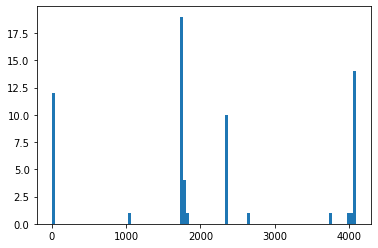

In [88]:
plt.hist([nnidx for nnidx, qidx_q_dist in found_idxs], bins=100)

In [89]:
[found_qkdist for found_idx, found_qkdist in found_idxs if found_idx<50]


[((0, 0, 2), ((0, 0, 2), (0, 0, 2)), 9.745415878370741e-30),
 ((0, 1, 0), ((0, 1, 0), (0, 1, 0)), 8.046776527068129e-30),
 ((0, 1, 2), ((0, 1, 2), (0, 1, 2)), 2.6964867105936242e-30),
 ((0, 2, 3), ((0, 2, 3), (0, 2, 3)), 2.172766925717152e-30),
 ((0, 3, 1), ((0, 3, 1), (0, 3, 1)), 7.3147771101321175e-31),
 ((0, 3, 3), ((0, 3, 3), (0, 3, 3)), 1.0731519605908131e-30),
 ((1, 0, 2), ((1, 0, 2), (1, 0, 2)), 8.374605104699816e-32),
 ((1, 1, 2), ((1, 1, 2), (1, 1, 2)), 4.684942592803084e-31),
 ((2, 2, 2), ((2, 2, 2), (2, 2, 2)), 1.4817429638152033e-30),
 ((2, 3, 2), ((2, 3, 2), (2, 3, 2)), 4.035687240621448e-30),
 ((3, 2, 2), ((3, 2, 2), (3, 2, 2)), 2.100409067225314e-30),
 ((3, 3, 2), ((3, 3, 2), (3, 3, 2)), 1.8105978053875652e-30)]

In [90]:
[found_qkdist for found_idx, found_qkdist in found_idxs if found_idx>700]


[((0, 0, 0), ((0, 0, 0), (0, 0, 0)), 2.08909688545751e-29),
 ((0, 0, 1), ((0, 0, 1), (0, 0, 1)), -4.559618731286171e-30),
 ((0, 0, 3), ((0, 0, 3), (0, 0, 3)), 2.011043060702001e-29),
 ((0, 1, 1), ((0, 1, 1), (0, 1, 1)), 0.0),
 ((0, 1, 3), ((0, 1, 3), (0, 1, 3)), -1.722713563102114e-30),
 ((0, 2, 0), ((0, 2, 0), (0, 2, 0)), 2.7707349806871867e-30),
 ((0, 2, 1), ((0, 2, 1), (0, 2, 1)), -8.202909298398401e-31),
 ((0, 2, 2), ((0, 2, 2), (0, 2, 2)), -2.7624488502154932e-30),
 ((0, 3, 0), ((0, 3, 0), (0, 3, 0)), -1.0253706292336177e-31),
 ((0, 3, 2), ((0, 3, 2), (0, 3, 2)), -9.48520804584923e-30),
 ((1, 0, 0), ((1, 0, 0), (1, 0, 0)), 1.412959705756408e-30),
 ((1, 0, 1), ((1, 0, 1), (1, 0, 1)), -1.3296166236536587e-30),
 ((1, 0, 3), ((1, 0, 3), (1, 0, 3)), 2.387563740764342e-30),
 ((1, 1, 0), ((1, 1, 0), (1, 1, 0)), 1.0046721014521839e-30),
 ((1, 1, 1), ((1, 1, 1), (1, 1, 1)), 4.6885867116484886e-30),
 ((1, 1, 3), ((1, 1, 3), (1, 1, 3)), 1.422558783044689e-30),
 ((1, 2, 0), ((1, 2, 0), (1, 2,

In [91]:
wrongs = (predictions != count_table).astype(int)

_, keep_querykeys33 = construct_filter(count_table, hparams, num_attr_shared_in_query=3, num_attr_hit_by_key=3)
_, keep_querykeys32 = construct_filter(count_table, hparams, num_attr_shared_in_query=3, num_attr_hit_by_key=2)
_, keep_querykeys31 = construct_filter(count_table, hparams, num_attr_shared_in_query=3, num_attr_hit_by_key=1)
_, keep_querykeys30 = construct_filter(count_table, hparams, num_attr_shared_in_query=3, num_attr_hit_by_key=0)

_, keep_querykeys22 = construct_filter(count_table, hparams, num_attr_shared_in_query=2, num_attr_hit_by_key=2)
_, keep_querykeys21 = construct_filter(count_table, hparams, num_attr_shared_in_query=2, num_attr_hit_by_key=1)
_, keep_querykeys20 = construct_filter(count_table, hparams, num_attr_shared_in_query=2, num_attr_hit_by_key=0)

_, keep_querykeys11 = construct_filter(count_table, hparams, num_attr_shared_in_query=1, num_attr_hit_by_key=1)
_, keep_querykeys10 = construct_filter(count_table, hparams, num_attr_shared_in_query=1, num_attr_hit_by_key=0)

_, keep_querykeys00 = construct_filter(count_table, hparams, num_attr_shared_in_query=0, num_attr_hit_by_key=0)

filters = {
"3-3":keep_querykeys33,
"3-2":keep_querykeys32,
"3-1":keep_querykeys31,
"3-0":keep_querykeys30,
"2-2":keep_querykeys22,
"2-1":keep_querykeys21,
"2-0":keep_querykeys20,
"1-1":keep_querykeys11,
"1-0":keep_querykeys10,
"0-0":keep_querykeys00,
}

for fil in filters:
    print(fil)
    print('error count',np.sum(filters[fil] * wrongs), '/', np.sum(filters[fil]))

3-3
error count 64.0 / 64.0
3-2
error count 576.0 / 576.0
3-1
error count 1728.0 / 1728.0
3-0
error count 64.0 / 1792.0
2-2
error count 2304.0 / 2304.0
2-1
error count 13824.0 / 13824.0
2-0
error count 576.0 / 21312.0
1-1
error count 27648.0 / 27648.0
1-0
error count 1728.0 / 84672.0
0-0
error count 0.0 / 110592.0


In [53]:
w_k, w_q = np.nonzero(wrongs)

total_match_count = 0

for q, k in zip(w_q, w_k):   
    w_q_prop = decode_query_idx_to_key_properties(game_data['num_attributes'], game_data['num_attr_vals'], q)
    w_q_prop = [tuple(w_q_prop[0]), tuple(w_q_prop[1])]
    w_k_prop = decode_key_idx(game_data['num_attributes'], game_data['num_attr_vals'], k)
    if tuple(set(w_q_prop)) == (tuple(w_k_prop),):
        total_match_count += 1
    print(f'{w_q_prop}\t{w_k_prop}')

[(1, 1, 2), (1, 1, 2)]	[0 0 0]
[(1, 1, 3), (1, 1, 3)]	[0 0 0]
[(1, 2, 1), (1, 2, 1)]	[0 0 0]
[(2, 1, 1), (2, 1, 1)]	[0 0 0]
[(2, 1, 2), (2, 1, 2)]	[0 0 0]
[(2, 1, 3), (2, 1, 3)]	[0 0 0]
[(2, 2, 3), (2, 2, 3)]	[0 0 0]
[(2, 3, 1), (2, 3, 1)]	[0 0 0]
[(2, 3, 2), (2, 3, 2)]	[0 0 0]
[(2, 3, 3), (2, 3, 3)]	[0 0 0]
[(3, 1, 1), (3, 1, 1)]	[0 0 0]
[(3, 1, 2), (3, 1, 2)]	[0 0 0]
[(3, 1, 3), (3, 1, 3)]	[0 0 0]
[(3, 2, 1), (3, 2, 1)]	[0 0 0]
[(3, 2, 2), (3, 2, 2)]	[0 0 0]
[(3, 3, 1), (3, 3, 1)]	[0 0 0]
[(3, 3, 2), (3, 3, 2)]	[0 0 0]
[(3, 3, 3), (3, 3, 3)]	[0 0 0]
[(1, 2, 2), (1, 2, 2)]	[0 0 1]
[(2, 1, 0), (2, 1, 0)]	[0 0 1]
[(2, 2, 0), (2, 2, 0)]	[0 0 1]
[(2, 3, 0), (2, 3, 0)]	[0 0 1]
[(3, 1, 0), (3, 1, 0)]	[0 0 1]
[(3, 2, 0), (3, 2, 0)]	[0 0 1]
[(3, 3, 0), (3, 3, 0)]	[0 0 1]
[(1, 1, 1), (1, 1, 1)]	[0 0 2]
[(2, 1, 0), (2, 1, 0)]	[0 0 2]
[(2, 2, 0), (2, 2, 0)]	[0 0 2]
[(2, 3, 0), (2, 3, 0)]	[0 0 2]
[(3, 1, 0), (3, 1, 0)]	[0 0 2]
[(3, 2, 0), (3, 2, 0)]	[0 0 2]
[(3, 3, 0), (3, 3, 0)]	[0 0 2]
[(1, 1, 

In [54]:
total_match_count

0

In [55]:
# distance of a query from other queries
for i in range(game_data['query_support_size']):
    q_prop = decode_query_idx_to_key_properties(game_data['num_attributes'], game_data['num_attr_vals'], i)
    print('query:' , q_prop)
    print(('NNs:\n'))
    nns, distances = find_nn(v=query_repr.T[i], Wv=query_repr.T, similarity_fn=find_dotproduct, k=20)
    for nni, dist in zip(nns, distances):
        q_prop2 = decode_query_idx_to_key_properties(game_data['num_attributes'], game_data['num_attr_vals'], nni)
        print(q_prop2, dist)
    print('---------------------------')

query: [array([0, 0, 0]), array([0, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([0, 0, 0])] 0.14517960992412246
[array([1, 3, 0]), array([1, 3, 0])] 0.07483928133434048
[array([1, 0, 3]), array([1, 0, 3])] 0.059817423702623065
[array([2, 0, 0]), array([2, 0, 0])] 0.055440501219216995
[array([1, 0, 2]), array([1, 0, 2])] 0.05482406367143475
[array([0, 2, 2]), array([0, 2, 2])] 0.049363092970572946
[array([1, 0, 1]), array([1, 0, 1])] 0.04690874086559238
[array([1, 1, 0]), array([1, 1, 0])] 0.04353609466474266
[array([1, 2, 0]), array([1, 2, 0])] 0.04317485224056568
[array([3, 0, 0]), array([3, 0, 0])] 0.03511010609016234
[array([1, 2, 1]), array([1, 2, 1])] 0.034306591097814434
[array([2, 1, 3]), array([2, 1, 3])] 0.031647709259328236
[array([0, 2, 3]), array([0, 2, 3])] 0.029138322532242435
[array([0, 0, 0]), array([0, 0, 3])] 0.025409092230429135
[array([0, 0, 0]), array([0, 1, 0])] 0.02540909223042846
[array([0, 0, 0]), array([0, 0, 1])] 0.02540909223042774
[array([0, 0, 0]), array([2

[array([0, 0, 1]), array([2, 0, 3])] 0.005035429867453289
[array([3, 0, 0]), array([2, 0, 3])] 0.005035429867453289
[array([3, 0, 0]), array([2, 0, 2])] 0.005035429867453289
[array([0, 0, 1]), array([3, 0, 3])] 0.005035429867453289
[array([3, 0, 3]), array([2, 0, 0])] 0.005035429867453289
[array([1, 0, 3]), array([0, 0, 2])] 0.005035429867453289
[array([0, 0, 1]), array([3, 0, 0])] 0.005035429867453289
[array([3, 0, 3]), array([1, 0, 2])] 0.005035429867453289
[array([0, 0, 1]), array([3, 0, 2])] 0.005035429867453289
[array([3, 0, 3]), array([2, 0, 2])] 0.005035429867453289
[array([3, 0, 0]), array([1, 0, 3])] 0.005035429867453289
---------------------------
query: [array([0, 0, 0]), array([1, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.0050354298674532665
[array([0, 0, 0]), array([3, 0, 2])] 0.005035429867453251
[array([0, 0, 0]), array([2, 0, 3])] 0.00503542986745325
[array([0, 0, 0]), array([2, 0, 1])] 0.00503542986745325
[array([3, 0, 3]), array([1, 0, 1])] 0.0050354298

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037267
[array([1, 2, 0]), array([3, 1, 3])] 0.0005787037037037252
[array([1, 3, 3]), array([2, 2, 0])] 0.0005787037037037252
[array([1, 3, 3]), array([3, 1, 0])] 0.0005787037037037252
[array([1, 3, 3]), array([3, 0, 2])] 0.0005787037037037252
[array([1, 3, 3]), array([3, 0, 1])] 0.0005787037037037252
[array([1, 3, 3]), array([3, 0, 0])] 0.0005787037037037252
[array([0, 0, 2]), array([1, 2, 1])] 0.0005787037037037252
[array([1, 3, 3]), array([2, 2, 2])] 0.0005787037037037252
---------------------------
query: [array([0, 0, 0]), array([1, 3, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037522
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037397
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037313
[array([0, 0, 0]), array([1, 2, 3])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037307
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037296
[array([0, 0, 0]), array([3, 3, 3

[array([1, 1, 1]), array([0, 1, 1])] 0.004560727571316021
[array([2, 1, 1]), array([0, 1, 1])] 0.004560727571316021
[array([0, 1, 1]), array([1, 1, 1])] 0.004560727571316021
---------------------------
query: [array([0, 0, 0]), array([3, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453287
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453271
[array([0, 0, 0]), array([3, 0, 2])] 0.005035429867453271
[array([0, 0, 3]), array([2, 0, 0])] 0.00503542986745327
[array([3, 0, 0]), array([1, 0, 3])] 0.00503542986745327
[array([2, 0, 1]), array([0, 0, 0])] 0.00503542986745327
[array([2, 0, 0]), array([3, 0, 3])] 0.00503542986745327
[array([2, 0, 0]), array([3, 0, 2])] 0.00503542986745327
[array([3, 0, 0]), array([1, 0, 2])] 0.00503542986745327
[array([2, 0, 0]), array([3, 0, 1])] 0.00503542986745327
[array([0, 0, 3]), array([2, 0, 2])] 0.00503542986745327
[array([0, 0, 3]), array([2, 0, 1])] 0.00503542986745327
[array([3, 0, 2]), array([1, 0, 0])] 0.00503542986745327


[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037313
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037303
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037297
[array([2, 3, 1]), array([3, 2, 3])] 0.0005787037037037282
[array([1, 2, 0]), array([2, 0, 1])] 0.0005787037037037282
[array([1, 2, 0]), array([0, 3, 2])] 0.0005787037037037282
[array([1, 2, 0]), array([0, 3, 3])] 0.0005787037037037282
[array([1, 2, 0]), array([0, 0, 2])] 0.0005787037037037282
[array([1, 2, 0]), array([2, 1, 1])] 0.0005787037037037282
[array([1, 2, 0]), array([2, 0, 2])] 0.0005787037037037282
[array([1, 2, 0]), array([2, 0, 3])] 0.0005787037037037282
---------------------------
query: [array([0, 0, 0]), array([3, 3, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037555
[array([0, 0, 0]), array([2, 3, 3])] 0.000578703703703743
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037346
[array([0, 0, 0]), array([1, 2, 3])] 0.0005787037037037341
[array([0, 0, 0]), array([2, 2, 1]

[array([2, 0, 1]), array([2, 0, 1])] 0.025409092230425576
[array([0, 0, 1]), array([0, 0, 1])] 0.02540909223042541
[array([1, 1, 0]), array([0, 1, 0])] 0.0045607275713159
[array([1, 1, 0]), array([2, 1, 0])] 0.0045607275713159
[array([2, 1, 0]), array([1, 1, 0])] 0.0045607275713159
[array([3, 1, 0]), array([1, 1, 0])] 0.0045607275713159
---------------------------
query: [array([0, 0, 1]), array([1, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 2])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.0050354298674532

[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 0, 1]), array([1, 3, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3]

[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 0])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 1])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 1])] 0.005035429867453272
---------------------------
query: [array([0, 0, 1]), array([3, 0, 1])]
NNs:

hit
[array([1, 0, 1]), array([2, 0, 1])] 0.044446650274713985
[array([2, 0, 1]), array([1, 0, 1])] 0.044446650

[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 0, 1]), array([3, 3, 1])]
NNs:

hit
[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.0

[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 2])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 0])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 1])] 0.005035429867453272
[array([0, 0

[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[array([0, 0, 0]), array([3, 0, 2])] 0.005035429867453273
[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 3])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 2]), array([0, 0, 0])] 0.04444665027471387
[array([0, 0, 0]), array([0, 0, 2])] 0.044446650274713735
[array([0, 0, 3]), array([0, 0, 3])] 0.02540909223042816
[array([0, 0, 0]), array([0, 0, 0])] 0.0254090922304254
[array([0, 0, 1]), array([0, 0, 1])] 0.0254090922304253
[array([0, 0, 2]), array([0, 0, 2])] 0.02540909223042393
[array([2, 1, 0]), array([2, 1, 2])] 0.0045607275713159
[array([2, 1, 3]), array([2, 1, 0])] 0.0045607275713159
[array([2, 1, 3]), array([2, 1, 2])] 0.0045607275713159
[array([2, 1, 2]), array([2, 1, 0])] 0.0045607275713159
---------------------------
query: [array([0, 0, 3]), array([0, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([0, 0, 3])] 0.04444665027471455
[array([0, 0, 0]), array([0, 0, 1])] 0.04444665027471432
[array([0, 0, 3]), array([0, 0, 0])] 0.04444665027471387
[array([0, 0, 3]), array([0, 0, 2])] 0.04444665027471387
[array([0, 0, 1]), array([0, 0, 0])] 0.04444665027471387
[array([0, 0, 1]), array([0, 0, 2])] 0.04444665027471387
[array([0, 

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 0, 3]), array([1, 1, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3

[array([0, 0, 3]), array([1, 0, 3])] 0.04444665027471397
[array([0, 0, 3]), array([3, 0, 3])] 0.04444665027471397
[array([3, 0, 3]), array([2, 0, 3])] 0.04444665027471397
[array([3, 0, 3]), array([1, 0, 3])] 0.04444665027471397
[array([0, 0, 3]), array([2, 0, 3])] 0.04444665027471397
[array([2, 0, 3]), array([0, 0, 3])] 0.04444665027471397
[array([2, 0, 3]), array([3, 0, 3])] 0.04444665027471397
[array([3, 0, 3]), array([0, 0, 3])] 0.04444665027471397
[array([1, 0, 3]), array([2, 0, 3])] 0.04444665027471397
[array([1, 0, 3]), array([3, 0, 3])] 0.04444665027471397
[array([1, 0, 3]), array([0, 0, 3])] 0.04444665027471397
[array([2, 0, 3]), array([1, 0, 3])] 0.04444665027471397
[array([0, 0, 3]), array([0, 0, 3])] 0.02540909223042573
[array([3, 0, 3]), array([3, 0, 3])] 0.025409092230425697
[array([2, 0, 3]), array([2, 0, 3])] 0.025409092230425673
[array([1, 0, 3]), array([1, 0, 3])] 0.02540909223042563
[array([2, 1, 0]), array([3, 1, 0])] 0.00456072757131589
[array([1, 1, 0]), array([3, 

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 0]), array([0, 2, 3])] 0.005035429867453282
[array([0, 0, 0]), array([0, 1, 3])] 0.005035429867453282
[array([0, 2, 0]), array([0, 0, 3])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 3])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 2])] 0.00503542986745328
[array([0, 3, 3]), array([0, 1, 0])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 3])] 0.00503542986745328
[array([0, 2, 1]), array([0, 0, 0])] 0.00503542986745328
---------------------------
query: [array([0, 1, 0]), array([0, 0, 3])]
NNs:

hit
[array([0, 0, 0]), array([0, 1, 1])] 0.0050354298674532925
[a

[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 2]), array([1, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1,

query: [array([0, 1, 0]), array([2, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[ar

[array([1, 0, 1]), array([0, 0, 1])] 0.0045607275713159
---------------------------
query: [array([0, 1, 0]), array([3, 1, 1])]
NNs:

hit
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array(

[array([2, 3, 2]), array([2, 1, 2])] 0.00456072757131589
[array([2, 1, 2]), array([2, 0, 2])] 0.00456072757131589
[array([2, 1, 2]), array([2, 2, 2])] 0.00456072757131589
---------------------------
query: [array([0, 1, 1]), array([0, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([0, 1, 1])] 0.0050354298674532925
[array([0, 0, 0]), array([0, 3, 1])] 0.005035429867453291
[array([0, 0, 0]), array([0, 3, 2])] 0.005035429867453289
[array([0, 0, 0]), array([0, 1, 2])] 0.005035429867453288
[array([0, 0, 0]), array([0, 2, 2])] 0.005035429867453285
[array([0, 0, 0]), array([0, 2, 3])] 0.005035429867453282
[array([0, 0, 0]), array([0, 1, 3])] 0.005035429867453282
[array([0, 2, 0]), array([0, 0, 3])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 1])] 0.0050354298674532

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 1, 1]), array([1, 1, 0])]
NNs:

hit
[array([3, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 1]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.0050354298

[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 2, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 3, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 1, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 2, 1])] 0.005035429867453282
[array([3, 0, 

[array([1, 1, 1]), array([0, 1, 1])] 0.04444665027471388
[array([1, 1, 1]), array([2, 1, 1])] 0.04444665027471388
[array([2, 1, 1]), array([0, 1, 1])] 0.04444665027471388
[array([2, 1, 1]), array([1, 1, 1])] 0.04444665027471388
[array([2, 1, 1]), array([3, 1, 1])] 0.04444665027471388
[array([1, 1, 1]), array([3, 1, 1])] 0.04444665027471388
[array([0, 1, 1]), array([3, 1, 1])] 0.04444665027471388
[array([0, 1, 1]), array([1, 1, 1])] 0.04444665027471388
[array([0, 1, 1]), array([2, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([0, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([1, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([2, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([3, 1, 1])] 0.025409092230425794
[array([1, 1, 1]), array([1, 1, 1])] 0.025409092230425784
[array([2, 1, 1]), array([2, 1, 1])] 0.02540909223042554
[array([0, 1, 1]), array([0, 1, 1])] 0.02540909223042545
[array([0, 0, 0]), array([1, 0, 0])] 0.004560727571316309
[array([0, 0, 0]), array([3,

[array([0, 0, 2]), array([0, 2, 2])] 0.04444665027471394
[array([0, 3, 2]), array([0, 0, 2])] 0.04444665027471394
[array([0, 2, 2]), array([0, 0, 2])] 0.04444665027471394
[array([0, 0, 2]), array([0, 1, 2])] 0.04444665027471394
[array([0, 1, 2]), array([0, 0, 2])] 0.04444665027471394
[array([0, 3, 2]), array([0, 2, 2])] 0.04444665027471394
[array([0, 2, 2]), array([0, 1, 2])] 0.04444665027471394
[array([0, 3, 2]), array([0, 1, 2])] 0.04444665027471394
[array([0, 1, 2]), array([0, 3, 2])] 0.04444665027471394
[array([0, 0, 2]), array([0, 3, 2])] 0.04444665027471394
[array([0, 2, 2]), array([0, 3, 2])] 0.04444665027471394
[array([0, 1, 2]), array([0, 2, 2])] 0.04444665027471394
[array([0, 3, 2]), array([0, 3, 2])] 0.025409092230425874
[array([0, 0, 2]), array([0, 0, 2])] 0.025409092230425808
[array([0, 1, 2]), array([0, 1, 2])] 0.025409092230425652
[array([0, 2, 2]), array([0, 2, 2])] 0.0254090922304253
[array([3, 1, 1]), array([3, 0, 1])] 0.0045607275713158806
[array([3, 2, 1]), array([3

[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 2]), array([1, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1,

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 2]), array([1, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([0, 1, 2]), array([3, 1, 2])]
NNs:

hit
[array([3, 1, 2]), array([0, 1, 2])] 0.044446650274713874
[arra

[array([0, 2, 0]), array([0, 1, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 3])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 2])] 0.00503542986745328
[array([0, 3, 3]), array([0, 1, 0])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 3])] 0.00503542986745328
[array([0, 2, 1]), array([0, 0, 0])] 0.00503542986745328
---------------------------
query: [array([0, 1, 3]), array([0, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([0, 1, 1])] 0.0050354298674532925
[array([0, 0, 0]), array([0, 3, 1])] 0.005035429867453291
[array([0, 0, 0]), array([0, 3, 2])] 0.005035429867453289
[array([0, 0, 0]), array([0, 1, 2])] 0.005035429867453288
[array([0, 0, 0]), array([0, 2, 2])] 0.005035429867453285
[array([0, 0, 0]), array([0, 2, 3])] 0.005035429867453282

hit
[array([1, 1, 3]), array([2, 1, 3])] 0.04444665027471397
[array([2, 1, 3]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([3, 1, 3])] 0.04444665027471397
[array([0, 1, 3]), array([3, 1, 3])] 0.04444665027471397
[array([2, 1, 3]), array([0, 1, 3])] 0.04444665027471397
[array([0, 1, 3]), array([1, 1, 3])] 0.04444665027471397
[array([3, 1, 3]), array([0, 1, 3])] 0.04444665027471397
[array([3, 1, 3]), array([1, 1, 3])] 0.04444665027471397
[array([3, 1, 3]), array([2, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([0, 1, 3])] 0.04444665027471397
[array([0, 1, 3]), array([2, 1, 3])] 0.04444665027471397
[array([2, 1, 3]), array([3, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 3])] 0.025409092230425787
[array([0, 1, 3]), array([0, 1, 3])] 0.025409092230425704
[array([2, 1, 3]), array([2, 1, 3])] 0.025409092230425645
[array([3, 1, 3]), array([3, 1, 3])] 0.025409092230425628
[array([0, 0, 0]), array([3, 0, 0])] 0.004560727571315915
[array([3, 0, 0]), arr

[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 3])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([0, 1, 3]), array([2, 1, 1])]
NNs:

hit
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array

[array([0, 1, 3]), array([1, 1, 3])] 0.04444665027471397
[array([3, 1, 3]), array([0, 1, 3])] 0.04444665027471397
[array([3, 1, 3]), array([1, 1, 3])] 0.04444665027471397
[array([3, 1, 3]), array([2, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([0, 1, 3])] 0.04444665027471397
[array([0, 1, 3]), array([2, 1, 3])] 0.04444665027471397
[array([2, 1, 3]), array([3, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 3])] 0.025409092230425787
[array([0, 1, 3]), array([0, 1, 3])] 0.025409092230425704
[array([2, 1, 3]), array([2, 1, 3])] 0.025409092230425645
[array([3, 1, 3]), array([3, 1, 3])] 0.025409092230425628
[array([0, 0, 0]), array([3, 0, 0])] 0.004560727571315915
[array([3, 0, 0]), array([0, 0, 0])] 0.004560727571315905
[array([1, 0, 0]), array([3, 0, 0])] 0.004560727571315905
[array([2, 0, 0]), array([3, 0, 0])] 0.004560727571315905
---------------------------
query: [array([0, 1, 3]), array([3, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037

[array([0, 0, 0]), array([0, 2, 3])] 0.005035429867453282
[array([0, 0, 0]), array([0, 1, 3])] 0.005035429867453282
[array([0, 2, 0]), array([0, 0, 3])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 3])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 2])] 0.00503542986745328
[array([0, 3, 3]), array([0, 1, 0])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 3])] 0.00503542986745328
[array([0, 2, 1]), array([0, 0, 0])] 0.00503542986745328
---------------------------
query: [array([0, 2, 0]), array([0, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([0, 1, 0])] 0.04444665027471457
[arr

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 0]), array([2, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429867453293
[array([0, 0, 0]), array([3, 3, 0])] 0.005035429867453289
[array([1, 1, 0]), array([2, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 1, 0])] 0.

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 3, 1]), array([0, 2, 1])] 0.044446650274713895
[array([0, 2, 1]), array([0, 0, 1])] 0.044446650274713895
[array([0, 1, 1]), array([0, 2, 1])] 0.044446650274713895
[array([0, 1, 1]), array([0, 3, 1])] 0.044446650274713895
[array([0, 1, 1]), array([0, 0, 1])] 0.044446650274713895
[array([0, 0, 1]), array([0, 3, 1])] 0.044446650274713895
[array([0, 0, 1]), array([0, 2, 1])] 0.044446650274713895
[array([0, 3, 1]), array([0, 1, 1])] 0.044446650274713895
[array([0, 3, 1]), array([0, 0, 1])] 0.044446650274713895
[array([0, 2, 1]), array([0, 3, 1])] 0.044446650274713895
[array([0, 0, 1]), array([0, 1, 1])] 0.044446650274713895
[array([0, 2, 1]), array([0, 1, 1])] 0.044446650274713895
[array([0, 1, 1]), array([0, 1, 1])] 0.02540909223042591
[array([0, 3, 1]), array([0, 3, 1])] 0.02540909223042568
[array([0, 2, 1]), array([0, 2, 1])] 0.02540909223042564
[array([0, 0, 1]), array([0, 0, 1])] 0.025409092230425333
[array([2, 3, 2]), array([2, 0, 2])] 0.00456072757131589
[array([2, 3, 2]),

---------------------------
query: [array([0, 2, 1]), array([1, 1, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3]

[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 1]), array([2, 0, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0]

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 1]), array([3, 1, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1]

[array([0, 0, 0]), array([0, 1, 1])] 0.0050354298674532925
[array([0, 0, 0]), array([0, 3, 1])] 0.005035429867453291
[array([0, 0, 0]), array([0, 3, 2])] 0.005035429867453289
[array([0, 0, 0]), array([0, 1, 2])] 0.005035429867453288
[array([0, 0, 0]), array([0, 2, 2])] 0.005035429867453285
[array([0, 0, 0]), array([0, 2, 3])] 0.005035429867453282
[array([0, 0, 0]), array([0, 1, 3])] 0.005035429867453282
[array([0, 2, 0]), array([0, 0, 3])] 0.00503542986745328
[array([0, 2, 0]), array([0, 3, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 2])] 0.00503542986745328
[array([0, 2, 0]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), array([0, 1, 3])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 2])] 0.00503542986745328
[array([0, 3, 3]), array([0, 1, 0])] 0.00503542986745328
[array([0, 3, 3]), array([0, 0, 1])] 0.00503542986745328
[array([0, 2, 0]), arra

[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 2]), ar

[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 2]), array([2, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3]

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 2]), array([3, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3

[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([0, 2, 2]), array([3, 3, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.00

[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 3]), array([1, 0, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745

[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 2, 3]), ar

query: [array([0, 2, 3]), array([3, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[ar

[array([3, 2, 3]), array([3, 2, 3])] 0.02540909223042559
[array([3, 0, 0]), array([2, 0, 0])] 0.004560727571315884
[array([2, 0, 0]), array([0, 0, 0])] 0.004560727571315884
[array([1, 0, 0]), array([3, 0, 0])] 0.004560727571315884
[array([3, 0, 0]), array([1, 0, 0])] 0.004560727571315884
---------------------------
query: [array([0, 2, 3]), array([3, 3, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0

[array([3, 0, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 1, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 0, 0])] 0.005035429867453287
[array([3, 3, 0]), array([2, 0, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([0, 3, 0]), array([1, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.000578703

[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([0, 3, 0]), array([1, 3, 2])]
NNs:

hit
[array([1, 3, 1]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 2])] 0.005035429867453284
[array([1, 3, 2]), array([2, 3, 3])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 3, 0]), array([3, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3]

[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
--------------

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 3, 1]), array([1, 1, 1])]
NNs:

hit
[array([0, 0, 1]), array([3, 1, 1

[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 3, 1]), array([2, 0, 1])]
NNs:

hit
[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 3, 1]), array([3, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3

[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
--------------

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 3, 2]), array([1, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1]

[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([0, 3, 2]), array([1, 3, 1])]
NNs:

hit
[array([1, 3, 1]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 2])] 0.005035429867453284
[array([1, 3, 2]), array([2, 3, 3])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429

[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([0, 3, 2]), array([3, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.00057

[array([1, 3, 1]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 2])] 0.005035429867453284
[array([1, 3, 2]), array([2, 3, 3])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 

[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([0, 3, 3]), array([1, 0, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])

[array([1, 3, 3]), array([3, 3, 3])] 0.044446650274713874
[array([3, 3, 3]), array([2, 3, 3])] 0.044446650274713874
[array([0, 3, 3]), array([1, 3, 3])] 0.044446650274713874
[array([0, 3, 3]), array([2, 3, 3])] 0.044446650274713874
[array([0, 3, 3]), array([3, 3, 3])] 0.044446650274713874
[array([1, 3, 3]), array([0, 3, 3])] 0.044446650274713874
[array([1, 3, 3]), array([2, 3, 3])] 0.044446650274713874
[array([2, 3, 3]), array([0, 3, 3])] 0.044446650274713874
[array([2, 3, 3]), array([1, 3, 3])] 0.044446650274713874
[array([2, 3, 3]), array([3, 3, 3])] 0.044446650274713874
[array([3, 3, 3]), array([0, 3, 3])] 0.044446650274713874
[array([3, 3, 3]), array([1, 3, 3])] 0.044446650274713874
[array([1, 3, 3]), array([1, 3, 3])] 0.025409092230425777
[array([2, 3, 3]), array([2, 3, 3])] 0.02540909223042568
[array([3, 3, 3]), array([3, 3, 3])] 0.02540909223042555
[array([0, 3, 3]), array([0, 3, 3])] 0.025409092230425548
[array([0, 0, 0]), array([1, 0, 0])] 0.004560727571315952
[array([0, 0, 0]

[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 1, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 2, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 1, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 2, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([0, 3, 3]), array([3, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[arr

[array([1, 3, 3]), array([3, 3, 3])] 0.044446650274713874
[array([3, 3, 3]), array([2, 3, 3])] 0.044446650274713874
[array([0, 3, 3]), array([1, 3, 3])] 0.044446650274713874
[array([0, 3, 3]), array([2, 3, 3])] 0.044446650274713874
[array([0, 3, 3]), array([3, 3, 3])] 0.044446650274713874
[array([1, 3, 3]), array([0, 3, 3])] 0.044446650274713874
[array([1, 3, 3]), array([2, 3, 3])] 0.044446650274713874
[array([2, 3, 3]), array([0, 3, 3])] 0.044446650274713874
[array([2, 3, 3]), array([1, 3, 3])] 0.044446650274713874
[array([2, 3, 3]), array([3, 3, 3])] 0.044446650274713874
[array([3, 3, 3]), array([0, 3, 3])] 0.044446650274713874
[array([3, 3, 3]), array([1, 3, 3])] 0.044446650274713874
[array([1, 3, 3]), array([1, 3, 3])] 0.025409092230425777
[array([2, 3, 3]), array([2, 3, 3])] 0.02540909223042568
[array([3, 3, 3]), array([3, 3, 3])] 0.02540909223042555
[array([0, 3, 3]), array([0, 3, 3])] 0.025409092230425548
[array([0, 0, 0]), array([1, 0, 0])] 0.004560727571315952
[array([0, 0, 0]

[array([1, 0, 2]), array([1, 0, 0])] 0.04444665027471397
[array([1, 0, 2]), array([1, 0, 1])] 0.04444665027471397
[array([1, 0, 2]), array([1, 0, 3])] 0.04444665027471397
[array([1, 0, 3]), array([1, 0, 0])] 0.04444665027471397
[array([1, 0, 3]), array([1, 0, 1])] 0.04444665027471397
[array([1, 0, 0]), array([1, 0, 1])] 0.04444665027471397
[array([1, 0, 1]), array([1, 0, 1])] 0.025409092230426023
[array([1, 0, 3]), array([1, 0, 3])] 0.025409092230425968
[array([1, 0, 2]), array([1, 0, 2])] 0.025409092230425763
[array([1, 0, 0]), array([1, 0, 0])] 0.025409092230424944
[array([0, 1, 0]), array([0, 1, 1])] 0.004560727571315911
[array([0, 1, 0]), array([0, 1, 3])] 0.004560727571315911
[array([0, 1, 3]), array([0, 1, 1])] 0.004560727571315911
[array([0, 1, 1]), array([0, 1, 3])] 0.004560727571315911
---------------------------
query: [array([1, 0, 0]), array([1, 0, 3])]
NNs:

hit
[array([1, 0, 0]), array([1, 0, 2])] 0.04444665027471397
[array([1, 0, 3]), array([1, 0, 2])] 0.0444466502747139

[array([1, 0, 0]), array([2, 0, 0])] 0.044446650274714235
[array([1, 0, 0]), array([3, 0, 0])] 0.044446650274714235
[array([2, 0, 0]), array([3, 0, 0])] 0.044446650274714235
[array([2, 0, 0]), array([0, 0, 0])] 0.044446650274714235
[array([2, 0, 0]), array([1, 0, 0])] 0.044446650274714235
[array([0, 0, 0]), array([1, 0, 0])] 0.044446650274713825
[array([0, 0, 0]), array([2, 0, 0])] 0.04444665027471319
[array([3, 0, 0]), array([3, 0, 0])] 0.025409092230426828
[array([1, 0, 0]), array([1, 0, 0])] 0.025409092230426637
[array([2, 0, 0]), array([2, 0, 0])] 0.02540909223042427
[array([0, 0, 0]), array([0, 0, 0])] 0.02540909223042238
[array([3, 3, 2]), array([1, 3, 2])] 0.0045607275713159135
[array([0, 3, 2]), array([1, 3, 2])] 0.0045607275713159135
[array([3, 3, 2]), array([0, 3, 2])] 0.0045607275713159135
[array([1, 3, 2]), array([3, 3, 2])] 0.0045607275713159135
---------------------------
query: [array([1, 0, 0]), array([2, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.00503542

[array([1, 2, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 0, 0])] 0.005035429867453287
[array([3, 3, 0]), array([2, 0, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([1, 0, 0]), array([3, 1, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787

[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 0])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 1])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 1])] 0.005035429867453272
---------------------------
query: [array([1, 0, 1]), array([0, 0, 1])]
NNs:

hit
[array([1, 0, 1]), array([2, 0, 1])] 0.044446650274713985
[array([2, 0, 1]), array([1, 0, 1])] 0.044446650274713985
[array([1, 0, 1]), array([3, 0, 1])] 0.044446650274713985
[array([3, 0, 1]), array([1, 0, 1])] 0.044446650274713985
[array([3, 0, 1]), array([0, 0, 1])] 0.044446650274713985
[array([2, 0, 1]), array([0, 0, 1])] 0.044446650274713985
[array([1, 0, 1]), array([0, 0, 1])] 0.044446650274713985
[array([3, 0, 1]), array([2, 0, 1])] 0.044446650274713985
[array([2, 0, 1]), array([3, 0, 1])] 0.044446650274713985
[array([0, 0, 1]), array([3, 0, 1])] 0.044446650274713985
[array([0, 0, 1]), array([2, 0, 1])] 0.044446650

[array([1, 0, 1]), array([1, 0, 3])] 0.04444665027471397
[array([1, 0, 2]), array([1, 0, 0])] 0.04444665027471397
[array([1, 0, 2]), array([1, 0, 1])] 0.04444665027471397
[array([1, 0, 2]), array([1, 0, 3])] 0.04444665027471397
[array([1, 0, 3]), array([1, 0, 0])] 0.04444665027471397
[array([1, 0, 3]), array([1, 0, 1])] 0.04444665027471397
[array([1, 0, 0]), array([1, 0, 1])] 0.04444665027471397
[array([1, 0, 1]), array([1, 0, 1])] 0.025409092230426023
[array([1, 0, 3]), array([1, 0, 3])] 0.025409092230425968
[array([1, 0, 2]), array([1, 0, 2])] 0.025409092230425763
[array([1, 0, 0]), array([1, 0, 0])] 0.025409092230424944
[array([0, 1, 0]), array([0, 1, 1])] 0.004560727571315911
[array([0, 1, 0]), array([0, 1, 3])] 0.004560727571315911
[array([0, 1, 3]), array([0, 1, 1])] 0.004560727571315911
[array([0, 1, 1]), array([0, 1, 3])] 0.004560727571315911
---------------------------
query: [array([1, 0, 1]), array([1, 0, 3])]
NNs:

hit
[array([1, 0, 0]), array([1, 0, 2])] 0.0444466502747139

[array([1, 1, 0]), array([1, 3, 1])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 0, 1]), array([1, 3, 3])]
NNs:

hit
[array([1, 1, 0]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 2]), array([1, 3, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 2])] 0.005035429

[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 2])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 0, 2]), array([1, 1, 1])]
NNs:

hit
[array([1, 1, 0]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 2]), array([1, 3, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 2])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 0])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 1])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429

[array([0, 0, 2]), array([1, 0, 0])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 1])] 0.005035429867453272
---------------------------
query: [array([1, 0, 2]), array([2, 0, 2])]
NNs:

hit
[array([1, 0, 2]), array([3, 0, 2])] 0.044446650274713936
[array([2, 0, 2]), array([3, 0, 2])] 0.044446650274713936
[array([1, 0, 2]), array([2, 0, 2])] 0.044446650274713936
[array([2, 0, 2]), array([1, 0, 2])] 0.044446650274713936
[array([2, 0, 2]), array([0, 0, 2])] 0.044446650274713936
[array([3, 0, 2]), array([2, 0, 2])] 0.044446650274713936
[array([3, 0, 2]), array([1, 0, 2])] 0.044446650274713936
[array([3, 0, 2]), array([0, 0, 2])] 0.044446650274713936
[array([0, 0, 2]), array([3, 0, 2])] 0.044446650274713936
[array([0, 0, 2]), array([2, 0, 2])] 0.044446650274713936
[array([0, 0, 2]), array([1, 0, 2])] 0.044446650274713936
[array([1, 0, 2]), array([0, 0, 2])] 0.044446650274713936
[array([1, 0, 2]), array([1, 0, 2])] 0.02540909223042604
[array([0, 0, 2]), array([0, 0, 2])] 0.0254090922

[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([1, 0, 2]), array([3, 1, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.000578703

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 0, 3]), array([0, 1, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3]

[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 0, 3]), array([1, 2, 2])]
NNs:

hit
[array([1, 1, 0]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 2]), array([1, 3, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 2])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 0])] 0.005035429

[array([1, 2, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 2, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([1, 0, 3]), array([2, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.000

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 0, 3]), array([3, 2, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 1, 3])] 0.0050354298674532

[array([1, 1, 2]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 2]), array([1, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([1, 1, 0]), array([0, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429867453293
[array([0, 0, 0]), array([3, 3, 0])] 0.005035429867453289
[ar

[array([1, 0, 1]), array([1, 1, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 1, 0]), array([1, 2, 3])]
NNs:

hit
[array([1, 1, 0]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 2]), array([1, 3, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 2])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 2])] 0.005035429

[array([2, 1, 0]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 3])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([1, 1, 0]), array([2, 1, 3])]
NNs:

hit
[array

[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([1, 1, 0]), array([3, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429867453293
[array([0, 0, 0]), array([3, 3, 0])] 0.005035429867453289
[array([1, 1, 0]), array([2, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 1, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 0, 0])] 0.005035429867453287
[array([3, 3, 0]), array([2, 0, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.0050354298

[array([3, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 1]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 3])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1,

[array([1, 1, 0]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 2]), array([1, 1, 1])] 0.04444665027471397
[array([1, 1, 0]), array([1, 1, 2])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 2])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 1])] 0.04444665027471397
[array([1, 1, 1]), array([1, 1, 0])] 0.04444665027471397
[array([1, 1, 1]), array([1, 1, 2])] 0.04444665027471397
[array([1, 1, 1]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 0]), array([1, 1, 1])] 0.04444665027471397
[array([1, 1, 2]), array([1, 1, 0])] 0.04444665027471397
[array([1, 1, 2]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 0])] 0.04444665027471397
[array([1, 1, 0]), array([1, 1, 0])] 0.02540909223042576
[array([1, 1, 3]), array([1, 1, 3])] 0.02540909223042567
[array([1, 1, 2]), array([1, 1, 2])] 0.025409092230425666
[array([1, 1, 1]), array([1, 1, 1])] 0.025409092230425652
[array([0, 0, 0]), array([0, 0, 1])] 0.004560727571316242
[array([0, 0, 0]), array([0,

[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 1, 1]), array([2, 0, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1]

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 1, 1]), array([3, 1, 0])]
NNs:

hit
[array([3, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 1]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 2])] 0.005035

[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 1, 2]), array([0, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2]

[array([1, 1, 0]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 2]), array([1, 1, 1])] 0.04444665027471397
[array([1, 1, 0]), array([1, 1, 2])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 2])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 1])] 0.04444665027471397
[array([1, 1, 1]), array([1, 1, 0])] 0.04444665027471397
[array([1, 1, 1]), array([1, 1, 2])] 0.04444665027471397
[array([1, 1, 1]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 0]), array([1, 1, 1])] 0.04444665027471397
[array([1, 1, 2]), array([1, 1, 0])] 0.04444665027471397
[array([1, 1, 2]), array([1, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 0])] 0.04444665027471397
[array([1, 1, 0]), array([1, 1, 0])] 0.02540909223042576
[array([1, 1, 3]), array([1, 1, 3])] 0.02540909223042567
[array([1, 1, 2]), array([1, 1, 2])] 0.025409092230425666
[array([1, 1, 1]), array([1, 1, 1])] 0.025409092230425652
[array([0, 0, 0]), array([0, 0, 1])] 0.004560727571316242
[array([0, 0, 0]), array([0,

query: [array([1, 1, 2]), array([2, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[ar

[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([2, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([1, 1, 2]), array([3, 1, 1])]
NNs:

hit
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([3, 1, 3])] 0.00503542986745328
[array

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 1, 3]), array([1, 0, 3])]
NNs:

hit
[array([1, 3, 3]), array([1, 2, 3])] 0.04444665027471388
[array([1, 0, 3]), array([1, 1, 3])] 0.04444665027471388
[array([1, 3, 3]), array([1, 0, 3])] 0.04444665027471388
[array([1, 1, 3]), array([1, 3, 3])] 0.04444665027471388
[array([1, 0, 3]), array([1, 2, 3])] 0.04444665027471388
[array([1, 2, 3]), array([1, 0, 3])] 0.04444665027471388
[array([1, 0, 3]), array([1, 3, 3])] 0.04444665027471388
[array([1, 1, 3]), array([1, 2, 3])] 0.0444466502747138

[array([1, 1, 0]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 2]), array([1, 3, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 2])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 0])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 1])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 1, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 2, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 1, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 2, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([1, 2, 0]), array([0, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429867453293
[array([0, 0, 0]), array([3, 3, 0])] 0.005035429867453289
[array([1, 1, 0]), array([2, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 1, 0])] 0.005035429867453287
[

[array([1, 1, 0]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 2]), array([1, 3, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 0])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 2])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 0, 0])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 3, 1])] 0.005035429867453279
[array([1, 0, 1]), array([1, 1, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 

[array([3, 0, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 1, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 0, 0])] 0.005035429867453287
[array([3, 3, 0]), array([2, 0, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([1, 2, 0]), array([2, 1, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.000578703

[array([3, 2, 0]), array([1, 2, 0])] 0.044446650274713964
[array([0, 2, 0]), array([0, 2, 0])] 0.02540909223042588
[array([3, 2, 0]), array([3, 2, 0])] 0.025409092230425766
[array([2, 2, 0]), array([2, 2, 0])] 0.02540909223042561
[array([1, 2, 0]), array([1, 2, 0])] 0.025409092230425468
[array([1, 0, 1]), array([2, 0, 1])] 0.004560727571315898
[array([1, 0, 1]), array([3, 0, 1])] 0.004560727571315898
[array([2, 0, 1]), array([3, 0, 1])] 0.004560727571315898
[array([2, 0, 1]), array([1, 0, 1])] 0.004560727571315898
---------------------------
query: [array([1, 2, 0]), array([3, 2, 1])]
NNs:

hit
[array([1, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([1, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([1, 2, 0]), array([2, 2, 3])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 1])] 0.005035429867453273
[array([0, 2, 3]), array([3, 2, 2])] 0.00503542986

[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 2, 1]), array([0, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2]

[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 2, 1]), array([1, 2, 0])]
NNs:

hit
[array([1, 2, 3]), array([1, 2, 2])] 0.044446650274713874
[array([1, 2, 1]), array([1, 2, 0])] 0.044446650274713874
[array([1, 2, 2]), array([1, 2, 1])] 0.044446650274713874
[array([1, 2, 2]), array([1, 2, 0])] 0.044446650274713874
[array([1, 2, 3]), array([1, 2, 1])] 0.044446650274713874
[array([1, 2, 1]), array([1, 2, 3])] 0.044446650274713874
[array([1, 2, 1]), array([1, 2, 2])] 0.044446650

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 2, 1]), array([2, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1]

[array([2, 2, 1]), array([0, 2, 1])] 0.04444665027471391
[array([3, 2, 1]), array([2, 2, 1])] 0.04444665027471391
[array([3, 2, 1]), array([1, 2, 1])] 0.04444665027471391
[array([3, 2, 1]), array([0, 2, 1])] 0.04444665027471391
[array([0, 2, 1]), array([3, 2, 1])] 0.04444665027471391
[array([0, 2, 1]), array([2, 2, 1])] 0.04444665027471391
[array([0, 2, 1]), array([1, 2, 1])] 0.04444665027471391
[array([2, 2, 1]), array([2, 2, 1])] 0.025409092230425777
[array([1, 2, 1]), array([1, 2, 1])] 0.025409092230425707
[array([0, 2, 1]), array([0, 2, 1])] 0.02540909223042556
[array([3, 2, 1]), array([3, 2, 1])] 0.025409092230425555
[array([0, 0, 0]), array([3, 0, 0])] 0.004560727571315957
[array([3, 0, 0]), array([1, 0, 0])] 0.004560727571315896
[array([2, 0, 0]), array([1, 0, 0])] 0.004560727571315896
[array([3, 0, 0]), array([2, 0, 0])] 0.004560727571315896
---------------------------
query: [array([1, 2, 1]), array([3, 2, 2])]
NNs:

hit
[array([2, 2, 1]), array([0, 2, 3])] 0.00503542986745327

[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 

query: [array([1, 2, 2]), array([1, 2, 3])]
NNs:

hit
[array([1, 2, 3]), array([1, 2, 2])] 0.044446650274713874
[array([1, 2, 1]), array([1, 2, 0])] 0.044446650274713874
[array([1, 2, 2]), array([1, 2, 1])] 0.044446650274713874
[array([1, 2, 2]), array([1, 2, 0])] 0.044446650274713874
[array([1, 2, 3]), array([1, 2, 1])] 0.044446650274713874
[array([1, 2, 1]), array([1, 2, 3])] 0.044446650274713874
[array([1, 2, 1]), array([1, 2, 2])] 0.044446650274713874
[array([1, 2, 2]), array([1, 2, 3])] 0.044446650274713874
[array([1, 2, 3]), array([1, 2, 0])] 0.044446650274713874
[array([1, 2, 0]), array([1, 2, 1])] 0.044446650274713874
[array([1, 2, 0]), array([1, 2, 2])] 0.044446650274713874
[array([1, 2, 0]), array([1, 2, 3])] 0.044446650274713874
[array([1, 2, 2]), array([1, 2, 2])] 0.0254090922304257
[array([1, 2, 1]), array([1, 2, 1])] 0.025409092230425655
[array([1, 2, 3]), array([1, 2, 3])] 0.025409092230425572
[array([1, 2, 0]), array([1, 2, 0])] 0.025409092230425548
[array([0, 0, 0]), a

[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 2, 2]), array([2, 2, 0])]
NNs:

hit
[array([2, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 2])] 0.0

[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 2, 2]), array([3, 3, 2])]
NNs:

hit
[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])]

[array([2, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 3])] 0.005035429867453273
[array([0, 2, 1]), array([2, 2, 3])] 0.005035429867453273
---------------------------
query: [array([1, 2, 3]), array([0, 2, 3])]
NNs:

hit
[array([3, 2, 3]), array([1, 2, 3])] 0.04444665027471392
[array([2, 2, 3]), array([1, 2, 3])] 0.04444665027471392
[array([2, 2, 3]), array([0, 2, 3])] 0.04444665027471392
[array([1, 2, 3]), array([3, 2, 3])] 0.04444665027471392
[array([1, 2, 3]), array([2, 2, 3])] 0.04444665027471392
[array([0, 2, 3]), array([3, 2, 3])] 0.04444665027471392
[array([2, 2, 3]), array([3, 2, 3])] 0.04444665027471392
[array([0, 2, 3]), array([2, 2, 3])] 0.04444665027471392
[array([1, 2, 3]), array([0, 2, 3])] 0.04444665027471392
[array([3, 2, 3]), array([0, 2, 3])] 0.04444665027471392
[array([0, 2, 3]), array([1, 2, 3])] 0.04444665027471392
[array([3, 2, 3]), array([2, 2, 3])] 0.04444665027471392
[a

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([3, 2, 0]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([2, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 3])] 0.005035429867453273
[array([0, 2, 1]), array([2, 2, 3])] 0.005035429867453273
---------------------------
query: [array([1, 2, 3]), array([2, 2, 3])]
NNs:

hit
[array([3, 2, 3]), array([1, 2, 3])] 0.04444665027471392
[array([2, 2, 3]), array([1, 2, 3])] 0.04444665027471392
[array([2, 2, 3]), array([0, 2, 3])] 0.04444665027471392
[array([1, 2, 3]), array([3, 2, 3])] 0.04444665027471392
[array([1, 2, 3]), array([2, 2, 3])] 0.04444665027471392
[array([0, 2, 3]), array([3, 2, 3])] 0.04444665027471

query: [array([1, 2, 3]), array([3, 3, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 1, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 2, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 1, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 0, 3]

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 3, 0]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 3]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 2])] 0.025409092230425798
[array([1, 3, 1]), array([1, 3, 1])] 0.025409092230425735
[array([1, 3, 3]), array([1, 3, 3])] 0.025409092230425593
[array([1, 3, 0]), array([1, 3, 0])] 0.02540909223042548
[array([0, 0, 0]), array([0, 0, 1])] 0.004560727571316073
[array([0, 0, 0]), array([0, 0, 3])] 0.004560727571315947
[array([3, 1, 1]), array([3, 1, 2])] 0.004560727571315871
[array([3, 1, 1]), array([3, 1, 0])] 0.004560727571315871
---------------------------
query: [array([1, 3, 0]), array([1, 3, 3])]
NNs:

hit
[array([1, 3, 3]), array([1, 3, 0])] 0.0444466502

[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 3, 0]), array([2, 2, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3

[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([1, 3, 0]), array([3, 3, 2])]
NNs:

hit
[array([1, 3, 1]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 2])] 0.005035429867453284
[array([1, 3, 2]), array([2, 3, 3])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429

[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 2, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 3, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 1, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 2, 1])] 0.005035429867453282
[array([3, 0, 

[array([1, 3, 3]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 3]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 0]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 0]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 0]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 3]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 2])] 0.025409092230425798
[array([1, 3, 1]), array([1, 3, 1])] 0.025409092230425735
[array([1, 3, 3]), array([1, 3, 3])] 0.025409092230425593
[array([1, 3, 0]), array([1, 3, 0])] 0.02540909223042548
[array([0, 0, 0]), array([0, 0, 1])] 0.004560727571316073
[array([0, 0, 0

[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 2, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 3, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 1, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 2, 1])] 0.005035429867453282
[array([3, 0, 

[array([0, 3, 1]), array([2, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([1, 3, 1])] 0.04444665027471392
[array([1, 3, 1]), array([0, 3, 1])] 0.04444665027471392
[array([1, 3, 1]), array([3, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([2, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([1, 3, 1])] 0.04444665027471392
[array([1, 3, 1]), array([2, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([0, 3, 1])] 0.04444665027471392
[array([0, 3, 1]), array([3, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([3, 3, 1])] 0.04444665027471392
[array([0, 3, 1]), array([1, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([0, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([2, 3, 1])] 0.02540909223042578
[array([3, 3, 1]), array([3, 3, 1])] 0.025409092230425666
[array([0, 3, 1]), array([0, 3, 1])] 0.02540909223042562
[array([1, 3, 1]), array([1, 3, 1])] 0.02540909223042561
[array([0, 0, 0]), array([3, 0, 0])] 0.0045607275713159135
[array([2, 0, 0]), array([0,

[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 3, 2]), array([0, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3

[array([1, 3, 3]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 3]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 0]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 0]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 0]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 0])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 3])] 0.044446650274713895
[array([1, 3, 3]), array([1, 3, 1])] 0.044446650274713895
[array([1, 3, 1]), array([1, 3, 2])] 0.044446650274713895
[array([1, 3, 2]), array([1, 3, 2])] 0.025409092230425798
[array([1, 3, 1]), array([1, 3, 1])] 0.025409092230425735
[array([1, 3, 3]), array([1, 3, 3])] 0.025409092230425593
[array([1, 3, 0]), array([1, 3, 0])] 0.02540909223042548
[array([0, 0, 0]), array([0, 0, 1])] 0.004560727571316073
[array([0, 0, 0

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 3, 2]), array([2, 1, 2])]
NNs:

hit
[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.00503

[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([1, 3, 2]), array([3, 2, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.000578

[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([1, 3, 3]), array([0, 1, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0]

[array([1, 0, 1]), array([1, 1, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 2, 1])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 3])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 2])] 0.005035429867453279
[array([1, 1, 0]), array([1, 0, 1])] 0.005035429867453279
[array([1, 0, 3]), array([1, 3, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 2])] 0.005035429867453279
[array([1, 1, 1]), array([1, 2, 3])] 0.005035429867453279
[array([1, 1, 1]), array([1, 3, 0])] 0.005035429867453279
---------------------------
query: [array([1, 3, 3]), array([1, 2, 3])]
NNs:

hit
[array([1, 3, 3]), array([1, 2, 3])] 0.04444665027471388
[array([1, 0, 3]), array([1, 1, 3])] 0.04444665027471388
[array([1, 3, 3]), array([1, 0, 3])] 0.04444665027471388
[array([1, 1, 3]), array([1, 3, 3])] 0.04444665027471388
[array([1, 0, 3]), array([1, 2, 3])] 0.04444665027471388
[array([1, 2, 3]), array([1, 0, 3])] 0.04444665027471

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([1, 3, 3]), array([3, 3, 3])]
NNs:

hit
[array([1, 3, 3]), array([3, 3, 3])] 0.044446650

[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([2, 0, 0]), array([0, 2, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.

[array([3, 0, 1]), array([3, 0, 1])] 0.0792287098090395
[array([3, 1, 0]), array([3, 1, 0])] 0.07773014340474844
[array([3, 0, 3]), array([3, 0, 3])] 0.07222374576527674
[array([3, 0, 2]), array([3, 0, 2])] 0.06981930190206022
[array([3, 2, 0]), array([3, 2, 0])] 0.06240618432184624
[array([0, 0, 0]), array([0, 0, 0])] 0.055440501219216995
[array([1, 2, 0]), array([1, 2, 0])] 0.037802617835025344
[array([1, 1, 0]), array([1, 1, 0])] 0.03758662392039991
[array([1, 0, 1]), array([1, 0, 1])] 0.035570052757044106
[array([2, 2, 2]), array([2, 2, 2])] 0.03518068250917594
[array([2, 2, 1]), array([2, 2, 1])] 0.03452300364081533
[array([0, 1, 3]), array([0, 1, 3])] 0.03266138993268151
[array([0, 2, 1]), array([0, 2, 1])] 0.032043171462697535
[array([1, 0, 2]), array([1, 0, 2])] 0.03083732635518443
[array([2, 3, 3]), array([2, 3, 3])] 0.030775489174500327
[array([2, 1, 2]), array([2, 1, 2])] 0.0279825381407525
[array([1, 0, 3]), array([1, 0, 3])] 0.027851698676658196
[array([2, 2, 3]), array([2

[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 0, 0]), array([2, 3, 0])]
NNs:

hit
[array([2, 1, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 2, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 1, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 1, 0])] 0.044446650274713916
[array([2, 2, 0]), array([2, 1, 0])] 0.04444665027471

[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 2, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 3, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 1, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 2, 1])] 0.005035429867453282
[array([3, 0, 

[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 2])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0

[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 0, 1]), array([2, 1, 3])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array

[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 0, 1]), array([3, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[arr

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([2, 0, 2]), array([0, 3, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.

[array([2, 0, 3]), array([2, 0, 1])] 0.044446650274713895
[array([2, 0, 3]), array([2, 0, 2])] 0.044446650274713895
[array([2, 0, 3]), array([2, 0, 3])] 0.025409092230425895
[array([2, 0, 0]), array([2, 0, 0])] 0.02540909223042571
[array([2, 0, 1]), array([2, 0, 1])] 0.025409092230425513
[array([2, 0, 2]), array([2, 0, 2])] 0.025409092230425465
[array([3, 3, 0]), array([3, 3, 1])] 0.0045607275713158936
[array([3, 3, 2]), array([3, 3, 3])] 0.0045607275713158936
[array([3, 3, 1]), array([3, 3, 3])] 0.0045607275713158936
[array([3, 3, 0]), array([3, 3, 2])] 0.0045607275713158936
---------------------------
query: [array([2, 0, 2]), array([2, 1, 0])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986

[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 0, 2]), array([2, 3, 1])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array

[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 0])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 1])] 0.005035429867453272
---------------------------
query: [array([2, 0, 3]), array([0, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 2])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.0050354

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 0, 3]), array([0, 2, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.0050354298

[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([2, 0, 3]), array([2, 0, 0])]
NNs:

hit
[array([2, 0, 1]), array([2, 0, 0])] 0.044446650274713895
[array([2, 0, 2]), array([2, 0, 3])] 0.044446650274713895
[array([2, 0, 0]), array([2, 0, 1])] 0.044446650274713895
[array([2, 0, 0]), array([2, 0, 2])] 0.044446650274713895
[array([2, 0, 0]), array([2, 0, 3])] 0.044446650274713895
[array([2, 0, 1]), array([2, 0, 2])] 0.044446650274713895
[array([2, 0, 1]), array([2, 0, 3])] 0.044446650274713895
[array([2, 0, 2]), array([2, 0, 1])] 0.044446650274713895
[array([2, 0, 2]), array([2, 0, 0])] 0.044446650274713895
[array([2, 0, 3]), array([2, 0, 0])] 0.044446650274713895
[array([2, 0, 3]), array([2, 0, 1])] 0.044446650274713895
[array([2, 0, 3]), array([2, 0, 2])] 0.044446650274713895
[array([2, 0, 3]), array([2, 0, 3])] 0.02540909223042589
[array([2, 0, 0]), array([2, 0, 0])] 0.025409092230425704
[array([2, 0, 1]), array([2, 0, 1])] 0.02540909223

[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 0, 3]), array([2, 2, 3])]
NNs:

hit
[array([2, 3, 3]), array([2, 1, 3])] 0.044446650274713985
[array([2, 1, 3]), array([2, 3, 3])] 0.044446650274713985
[array([2, 1, 3]), array([2, 2, 3])] 0.044446650274713985
[array([2, 2, 3]), array([2, 1, 3])] 0.044446650274713985
[array([2, 1, 3]), array([2, 0, 3])] 0.044446650274713985
[array([2, 2, 3]), array([2, 0, 3])] 0.044446650274713985
[array([2, 3, 3]), array([2, 0, 3])] 0.044446650274713985
[array([2, 0, 3]), array([2, 3, 3])] 0.044446650274713985
[array([2, 0, 3]), array([2, 2, 3])] 0.044446650274713985
[array([2, 2, 3]), array([2, 3, 3])] 0.044446650274713985
[array([2, 0, 3]), array([2, 1, 3])] 0.04444665027471

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 0]), array([0, 2, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3]

[array([2, 1, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 1, 0])] 0.044446650274713916
[array([2, 2, 0]), array([2, 1, 0])] 0.044446650274713916
[array([2, 2, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 1, 0])] 0.025409092230425846
[array([2, 3, 0]), array([2, 3, 0])] 0.025409092230425787
[array([2, 0, 0]), array([2, 0, 0])] 0.02540909223042576
[array([2, 2, 0]), array([2, 2, 0])] 0.02540909223042526
[array([0, 3, 3]), array([0, 1, 3])] 0.0045607275713158806
[array([0, 2, 3]), array([0, 3, 3])] 0.0045607275713158806
[array([0, 2, 3]), array([0, 1, 3])] 0.0045607275713158806
[array([0, 2, 3]), array([0, 0, 3])] 0.0045607275713158806
---------------------------
query: [array([2, 1, 0]), array([2, 0, 1])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.0050354

[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 1, 0]), array([2, 2, 2])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 1]), array([0, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3

[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 1]), array([0, 2, 1])]
NNs:

hit
[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])]

[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 1]), array([1, 3, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2]

[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0,

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 1]), array([3, 3, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3]

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 2]), array([0, 2, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3]

[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0,

[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 1, 2]), array([2, 2, 1])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array

[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([2, 1, 2]), array([3, 3, 3])]


query: [array([2, 1, 3]), array([0, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[ar

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 3]), array([1, 3, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.0050354298

[array([3, 0, 3]), array([3, 0, 3])] 0.04705146643375712
[array([2, 0, 2]), array([2, 0, 2])] 0.04692597203537641
[array([2, 2, 0]), array([2, 2, 0])] 0.044963627794889265
[array([1, 1, 1]), array([1, 1, 1])] 0.04429851280656051
[array([0, 3, 3]), array([0, 3, 3])] 0.04385790620742207
[array([1, 2, 3]), array([1, 2, 3])] 0.042324195620211814
[array([0, 1, 1]), array([0, 1, 1])] 0.04185774278882263
[array([1, 3, 3]), array([1, 3, 3])] 0.04162694175132574
[array([0, 2, 3]), array([0, 2, 3])] 0.04123829754086954
[array([1, 1, 0]), array([1, 1, 0])] 0.03931563382870649
[array([3, 2, 3]), array([3, 2, 3])] 0.038810833886877213
[array([2, 2, 2]), array([2, 2, 2])] 0.03877829241511703
[array([2, 2, 1]), array([2, 2, 1])] 0.038631406837952194
[array([1, 1, 2]), array([1, 1, 2])] 0.03747843259702108
[array([3, 1, 2]), array([3, 1, 2])] 0.037240584350527975
---------------------------
query: [array([2, 1, 3]), array([2, 2, 0])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[

[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 1, 3]), array([3, 3, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2]

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 2, 3]), array([3, 2, 1])] 0.005035429867453273
[array([0, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 0])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 1])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 0])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 0])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 2])] 0.005035429867453273
---------------------------
query: [array([2, 2, 0]), array([1, 3, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429

[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 2, 0]), array([2, 1, 0])]
NNs:

hit
[array([2, 1, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 2, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 1, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 3, 0])] 0.0444466502747139

[array([0, 2, 0]), array([3, 2, 2])] 0.005035429867453273
---------------------------
query: [array([2, 2, 0]), array([3, 2, 2])]
NNs:

hit
[array([2, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 2])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 3])] 0.005035429

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 0])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 1])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 0])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 0])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 2])] 0.005035429867453273
---------------------------
query: [array([2, 2, 1]), array([1, 3, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.00057870

[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 2, 1]), array([2, 1, 0])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array

[array([1, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([1, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([1, 2, 0]), array([2, 2, 3])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 1])] 0.005035429867453273
[array([0, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 3]), array([3, 2, 0])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 1])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 2])] 0.005035429867453273
[array([1, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 0])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 0])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([3, 2, 

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 2, 2]), array([0, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2]

[array([2, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 2])] 0.005035429867453273
---------------------------
query: [array([2, 2, 2]), array([1, 2, 2])]
NNs:

hit
[array([1, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([1, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([1, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([3, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([3, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([3, 2

[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 2, 2]), array([2, 0, 2])]
NNs:

hit
[array([2, 2, 2]), array([2, 1, 2])] 0.0444466502747139
[array([2, 3, 2]), array([2, 0, 2])] 0.0444466502747139
[array([2, 1, 2]), array([2, 2, 2])] 0.0444466502747139
[array([2, 3, 2]), array([2, 2, 2])] 0.0444466502747139
[array([2, 3, 2]), array([2, 1, 2])] 0.0444466502747139
[array([2, 0, 2]), array([2, 2, 2])] 0.0444466502747139
[array([2, 0, 2]), array([2, 1, 2])] 0.0444466502747139
[array([2, 1, 2]), array([2, 0, 2])] 0.0444466502747139
[array([2, 0, 2]), array([2, 3, 2])] 0.0444466502747139
[array([2, 1, 2]), array([2, 3, 2])] 0.0444466502747139
[array([2, 2, 2]), array([2, 0, 2])] 0.0444466502747139
[array([2, 2, 2]), array([2, 3, 2])] 0.0444466502747139
[array([2, 2, 2]),

[array([3, 2, 2]), array([0, 2, 0])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 0])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 2])] 0.005035429867453273
---------------------------
query: [array([2, 2, 2]), array([3, 2, 2])]
NNs:

hit
[array([1, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([1, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([1, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[arr

[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 2, 3]), array([0, 0, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1]

[array([1, 2, 1]), array([0, 2, 0])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 3])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([3, 2, 2]), array([0, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 3])] 0.005035429867453273
[array([0, 2, 0]), array([3, 2, 2])] 0.005035429867453273
---------------------------
query: [array([2, 2, 3]), array([1, 2, 2])]
NNs:

hit
[array([2, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 2])] 0.005035429

[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 2, 3]), array([2, 0, 3])]
NNs:

hit
[array([2, 3, 3]), array([2, 1, 3])] 0.044446650274713985
[array([2, 1, 3]), array([2, 3, 3])] 0.044446650274713985
[array([2, 1, 3]), array([2, 2, 3])] 0.044446650274713985
[array([2, 2, 3]), array([2, 1, 3])] 0.044446650274713985
[array([2, 1, 3]), array([2, 0, 3])] 0.044446650274713985
[array([2, 2, 3]), array([2, 0, 3])] 0.044446650274713985
[array([2, 3, 3]), array([2, 0, 3])] 0.044446650274713985
[array([2, 0, 3]), array([2, 3, 3])] 0.044446650274713985
[array([2, 0, 3]), array([2, 2, 3])] 0.044446650274713985
[array([2, 2, 3]), array([2, 3, 3])] 0.044446650274713985
[array([2, 0, 3]), array([2, 1, 3])] 0.044446650274713985
[array([2, 3, 3]), array([2, 2, 3])] 0.044446650274713985
[array([2, 3, 3]), array([2, 3, 3])] 0.025409092230

query: [array([2, 2, 3]), array([3, 2, 2])]
NNs:

hit
[array([2, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 2])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([2, 2, 3]),

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 3, 0]), array([0, 0, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1]

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 3, 0]), array([1, 3, 0])]
NNs:

hit
[array([3, 3, 0]), array([0, 3, 0])] 0.04444665027471393
[array([0, 3, 0]), array([1, 3, 0])] 0.04444665027471393
[array([1, 3, 0]), array([2, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([1, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 3, 0]), array([2, 3, 0])] 0.04444665027471393
[array([1, 3, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 3, 0]), array([1, 3, 0])] 0.04444665027471393
[array([1, 3, 0]), array([0, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([0, 3, 0])] 0.04444665027471393
[array([0, 3, 0]), array([3, 3, 0])] 0.04444665027471393
[array([0, 3, 0]), array([2, 3, 0])] 0.0444466502747139

[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 3, 0]), array([2, 1, 0])]
NNs:

hit
[array([2, 1, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 2, 0]), array([2, 3, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 1, 0])] 0.044446650274713916
[array([2, 3, 0]), array([2, 0, 0])] 0.044446650274713916
[array([2, 1, 0]), array([2, 2, 0])] 0.044446650274713916
[array([2, 0, 0]), array([2, 3, 0])] 0.044446650274713916

[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 3, 0]), array([3, 2, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0]

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 3, 1]), array([2, 1, 0])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array

[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 3, 1]), array([3, 2, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3]

[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 3, 2]), array([0, 1, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1]

[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([2, 3, 2]), array([1, 2, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 

[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0,

[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 

[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 1, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 2, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 1, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 2,

[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([2, 3, 3]), array([1, 2, 3])]
NNs:

hit
[array([1, 2, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 1, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([2, 3, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745

[array([2, 2, 2]), array([2, 1, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 2])] 0.00503542986745329
[array([2, 2, 2]), array([2, 1, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 1, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 0])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 3])] 0.00503542986745329
[array([2, 2, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 2])] 0.00503542986745329
[array([2, 0, 3]), array([2, 3, 1])] 0.00503542986745329
[array([2, 2, 2]), array([2, 0, 0])] 0.00503542986745329
[array([2, 1, 0]), array([2, 0, 1])] 0.00503542986745329
[array([2, 3, 1]), array([2, 0, 0])] 0.00503542986745329
---------------------------
query: [array([2, 3, 3]), array([2, 1, 2])]
NNs:

hit
[array([2, 1, 2]), array([2, 3, 3])] 0.00503542986745329
[array([2, 3, 1]), array([2, 2, 0])] 0.00503542986745329
[array

[array([1, 1, 3]), array([3, 0, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([3, 3, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 1, 3])] 0.00503542986745329
[array([1, 2, 3]), array([0, 3, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 2, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 1, 3])] 0.00503542986745329
[array([2, 3, 3]), array([0, 0, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 0, 3])] 0.00503542986745329
[array([2, 3, 3]), array([1, 2, 3])] 0.00503542986745329
[array([1, 1, 3]), array([0, 2, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([2, 3, 3]), array([3, 3, 0])]
NNs:

hit
[array([1, 3, 1]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 2])] 0.005035429867453284
[array([1, 3, 2]), array([2, 3, 3])] 0.005035429867453284
[ar

[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429867453272
[array([3, 0, 1]), array([2, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 0])] 0.005035429867453272
[array([0, 0, 3]), array([3, 0, 2])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 0])] 0.005035429867453272
[array([0, 0, 2]), array([1, 0, 1])] 0.005035429867453272
---------------------------
query: [array([3, 0, 0]), array([0, 1, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429

[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429867453293
[array([0, 0, 0]), array([3, 3, 0])] 0.005035429867453289
[array([1, 1, 0]), array([2, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 1, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 0, 0])] 0.005035429867453287
[array([3, 3, 0]), array([2, 0, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 

[array([1, 2, 0]), array([0, 3, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([1, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 0, 0])] 0.005035429867453287
[array([3, 3, 0]), array([2, 0, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([3, 0, 0]), array([2, 1, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787

[array([3, 1, 0]), array([3, 0, 0])] 0.04444665027471393
[array([3, 1, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 2, 0])] 0.04444665027471393
[array([3, 2, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 3, 0]), array([3, 0, 0])] 0.04444665027471393
[array([3, 3, 0]), array([3, 1, 0])] 0.04444665027471393
[array([3, 3, 0]), array([3, 2, 0])] 0.04444665027471393
[array([3, 1, 0]), array([3, 2, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 1, 0])] 0.04444665027471393
[array([3, 2, 0]), array([3, 1, 0])] 0.04444665027471393
[array([3, 2, 0]), array([3, 0, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 0, 0])] 0.025409092230426214
[array([3, 3, 0]), array([3, 3, 0])] 0.02540909223042611
[array([3, 1, 0]), array([3, 1, 0])] 0.025409092230425423
[array([3, 2, 0]), array([3, 2, 0])] 0.02540909223042492
[array([1, 1, 2]), array([1, 0, 2])] 0.004560727571315889
[array([1, 2, 2]), array([1,

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 0, 1]), array([0, 1, 1])]
NNs:

hit
[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 2, 1])] 0.00

[array([0, 0, 1]), array([3, 1, 1])] 0.005035429867453282
[array([2, 0, 1]), array([3, 2, 1])] 0.005035429867453282
[array([2, 2, 1]), array([1, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 0, 1])] 0.005035429867453282
[array([1, 1, 1]), array([3, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 2, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 3, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([0, 3, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 1, 1])] 0.005035429867453282
[array([0, 3, 1]), array([3, 2, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 1, 1])] 0.005035429867453282
[array([1, 1, 1]), array([2, 0, 1])] 0.005035429867453282
[array([3, 0, 1]), array([1, 2, 1])] 0.005035429867453282
[array([3, 0, 

[array([2, 0, 1]), array([3, 3, 1])] 0.005035429867453282
[array([2, 0, 1]), array([1, 3, 1])] 0.005035429867453282
---------------------------
query: [array([3, 0, 1]), array([2, 1, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])]

[array([3, 0, 2]), array([3, 2, 0])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 2, 2]), array([3, 3, 0])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 1])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 3])] 0.005035429867453276
---------------------------
query: [array([3, 0, 1]), array([3, 3, 3])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429

[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 

[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 2, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 1, 2])] 0.005035429867453278
[array([0, 0, 2]), array([1, 3, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 3, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 0, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 0, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 0, 2]), array([2, 1, 2])]
NNs:

hit
[array([3, 2, 2]), array([1, 0, 2

[array([3, 1, 2]), array([3, 0, 2])] 0.04444665027471402
[array([3, 3, 2]), array([3, 1, 2])] 0.04444665027471402
[array([3, 0, 2]), array([3, 1, 2])] 0.04444665027471402
[array([3, 0, 2]), array([3, 2, 2])] 0.04444665027471402
[array([3, 0, 2]), array([3, 3, 2])] 0.04444665027471402
[array([3, 3, 2]), array([3, 2, 2])] 0.04444665027471402
[array([3, 2, 2]), array([3, 0, 2])] 0.04444665027471402
[array([3, 2, 2]), array([3, 1, 2])] 0.04444665027471402
[array([3, 1, 2]), array([3, 2, 2])] 0.04444665027471402
[array([3, 1, 2]), array([3, 3, 2])] 0.04444665027471402
[array([3, 2, 2]), array([3, 3, 2])] 0.04444665027471402
[array([3, 3, 2]), array([3, 0, 2])] 0.04444665027471402
[array([3, 1, 2]), array([3, 1, 2])] 0.02540909223042577
[array([3, 3, 2]), array([3, 3, 2])] 0.02540909223042576
[array([3, 2, 2]), array([3, 2, 2])] 0.02540909223042573
[array([3, 0, 2]), array([3, 0, 2])] 0.02540909223042554
[array([0, 0, 0]), array([0, 3, 0])] 0.004560727571316116
[array([0, 0, 0]), array([0, 2

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([1, 1, 3]), array([0, 2, 3])] 0.00503542986745329
[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([3, 0, 3]), array([2, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 0, 1])] 0.005035429867453289
[array([0, 0, 0]), array([2, 0, 1])] 0.005035429867453273
[array([0, 0, 0]), array([2, 0, 3])] 0.0050354298674532725
[array([0, 0, 0]), array([3, 0, 2])] 0.0050354298674532725
[array([3, 0, 2]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 1]), array([3, 0, 2])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 1])] 0.005035429867453272
[array([3, 0, 2]), array([0, 0, 0])] 0.005035429867453272
[array([2, 0, 0]), array([0, 0, 3])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 2])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([1, 0, 0])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 1])] 0.005035429867453272
[array([2, 0, 3]), array([0, 0, 2])] 0.005035429

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 0, 3]), array([2, 2, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3

[array([3, 2, 3]), array([3, 3, 3])] 0.044446650274713964
[array([3, 2, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 2, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 1, 3]), array([3, 3, 3])] 0.044446650274713964
[array([3, 1, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 1, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 3, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 3, 3])] 0.025409092230425787
[array([3, 0, 3]), array([3, 0, 3])] 0.02540909223042576
[array([3, 2, 3]), array([3, 2, 3])] 0.0254090922304256
[array([3, 1, 3]), array([3, 1, 3])] 0.025409092230425524
[array([0, 1, 0]), array([0, 2, 0])] 0.00456072757131592
[array([0, 1, 0]),

[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 2]), array([1, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([3, 1, 0]), array([0, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.005035429867453295
[array([0, 0, 0]), array([1, 1, 0])] 0.005035429867453293
[array([0, 0, 0]), array([3, 3, 0])] 0.005035429867453289
[array([1, 1, 0]), array([2, 3, 0])] 0.005035429867453287
[array([1, 2, 0]), array([0, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 3, 0])] 0.005035429867453287


[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([3, 1, 0]), array([1, 3, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])

[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([3, 1, 0]), array([2, 1, 2])]
NNs:

hit
[array([3, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 1]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 1])] 0.00503542986745328
[array([0, 1, 3]), array([3, 1, 0])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 3])] 0.00503542986745328
[array([2, 1, 3]), array([1, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array

[array([3, 2, 0]), array([3, 2, 0])] 0.02540909223042492
[array([1, 1, 2]), array([1, 0, 2])] 0.004560727571315889
[array([1, 2, 2]), array([1, 3, 2])] 0.004560727571315889
[array([1, 3, 2]), array([1, 2, 2])] 0.004560727571315889
[array([1, 3, 2]), array([1, 1, 2])] 0.004560727571315889
---------------------------
query: [array([3, 1, 0]), array([3, 3, 1])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 3])] 0.0050354298

[array([0, 1, 1]), array([3, 1, 1])] 0.04444665027471388
[array([0, 1, 1]), array([1, 1, 1])] 0.04444665027471388
[array([0, 1, 1]), array([2, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([0, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([1, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([2, 1, 1])] 0.04444665027471388
[array([3, 1, 1]), array([3, 1, 1])] 0.025409092230425794
[array([1, 1, 1]), array([1, 1, 1])] 0.025409092230425784
[array([2, 1, 1]), array([2, 1, 1])] 0.02540909223042554
[array([0, 1, 1]), array([0, 1, 1])] 0.02540909223042545
[array([0, 0, 0]), array([1, 0, 0])] 0.004560727571316309
[array([0, 0, 0]), array([3, 0, 0])] 0.004560727571316021
[array([3, 0, 0]), array([2, 0, 0])] 0.004560727571315901
[array([2, 0, 0]), array([1, 0, 0])] 0.004560727571315901
---------------------------
query: [array([3, 1, 1]), array([0, 1, 2])]
NNs:

hit
[array([3, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328


[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 1, 1]), array([1, 3, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 1, 1]), array([2, 0, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2]

[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 2, 0])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 2, 2]), array([3, 3, 0])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 1])] 0.005035429867453276
[array([3, 2, 

[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 1, 2]), array([0, 0, 2])]
NNs:

hit
[array([3, 2, 2]), array([1, 0, 2])] 0.005035429867453278
[array([3, 1, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 2, 2])] 0.005035429867453278
[array([3, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 1, 2])] 0.005035429867453278
[array([1, 2, 2]), array([0, 0, 2])] 0.005035429867453278
[array([3, 3, 2]), array([0, 2, 2])] 0.005035429867453278
[array([0, 3, 2]), array([3, 1, 2])] 0.00

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([3, 2, 2]), array([3, 3, 0])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 1])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 3])] 0.005035429867453276
---------------------------
query: [array([3, 1, 2]), array([3, 3, 2])]
NNs:

hit
[array([3, 1, 2]), array([3, 0, 2])] 0.04444665027471402
[array([3, 3, 2]), array([3, 1, 2])] 0.04444665027471402
[array([3, 0, 2]), array([3, 1, 2])] 0.04444665027471402
[array([3, 0, 2]), array([3, 2, 2])] 0.04444665027471402
[array([3, 0, 2]), array([3, 3, 2])] 0.04444665027471402
[array([3, 3, 2]), array([3, 2, 2])] 0.04444665027471402
[array([3, 2, 2]), array([3, 0, 2])] 0.04444665027471402
[array([3, 2, 2]), array([3, 1, 2])] 0.04444665027471402
[array([3, 1, 2]), array([3, 2, 2])] 0.04444665027471402
[array([3, 1, 2]), array([3, 3, 2])] 0.04444665027471402
[array([3, 2, 2]), array([3, 3, 2])] 0.04444665027471402
[

[array([0, 1, 3]), array([2, 1, 1])] 0.00503542986745328
[array([1, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([0, 1, 3]), array([2, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 2])] 0.00503542986745328
[array([2, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 0]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 2]), array([1, 1, 3])] 0.00503542986745328
[array([1, 1, 3]), array([0, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 2])] 0.00503542986745328
[array([0, 1, 3]), array([1, 1, 1])] 0.00503542986745328
---------------------------
query: [array([3, 1, 3]), array([0, 1, 2])]
NNs:

hit
[array([3, 1, 1]), array([0, 1, 0])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 0])] 0.00503542986745328
[array([2, 1, 1]), array([3, 1, 3])] 0.00503542986745328
[array([1, 1, 2]), array([0, 1, 3])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 1])] 0.00503542986745328
[array([2, 1, 0]), array([1, 1, 2])] 0.00503542986745328
[array

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([2, 1, 3]), array([3, 1, 3])] 0.04444665027471397
[array([1, 1, 3]), array([1, 1, 3])] 0.025409092230425787
[array([0, 1, 3]), array([0, 1, 3])] 0.025409092230425704
[array([2, 1, 3]), array([2, 1, 3])] 0.025409092230425645
[array([3, 1, 3]), array([3, 1, 3])] 0.025409092230425628
[array([0, 0, 0]), array([3, 0, 0])] 0.004560727571315915
[array([3, 0, 0]), array([0, 0, 0])] 0.004560727571315905
[array([1, 0, 0]), array([3, 0, 0])] 0.004560727571315905
[array([2, 0, 0]), array([3, 0, 0])] 0.004560727571315905
---------------------------
query: [array([3, 1, 3]), array([2, 2, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.00057

[array([3, 1, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 1, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 3, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 3, 3])] 0.025409092230425787
[array([3, 0, 3]), array([3, 0, 3])] 0.02540909223042576
[array([3, 2, 3]), array([3, 2, 3])] 0.0254090922304256
[array([3, 1, 3]), array([3, 1, 3])] 0.025409092230425524
[array([0, 1, 0]), array([0, 2, 0])] 0.00456072757131592
[array([0, 1, 0]), array([0, 0, 0])] 0.00456072757131592
[array([0, 3, 0]), array([0, 2, 0])] 0.00456072757131592
[array([0, 3, 0]), array([0, 1, 0])] 0.00456072757131592
---------------------------
query: [array([3, 2, 0]), array([0, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([1, 2, 0])] 0.0050354298674532

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 2, 0]), array([2, 1, 2])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3]

[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 2, 0])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 2, 2]), array([3, 3, 0])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 1])] 0.005035429867453276
[array([3, 2, 

query: [array([3, 2, 1]), array([0, 1, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[ar

[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 2, 1]), array([2, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1]

[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 2, 1]), array([2, 1, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2]

[array([3, 0, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 2, 2]), array([3, 3, 0])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 1])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 3])] 0.005035429867453276
---------------------------
query: [array([3, 2, 2]), array([0, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0

[array([1, 1, 2]), array([3, 2, 2])] 0.005035429867453278
[array([1, 1, 2]), array([3, 0, 2])] 0.005035429867453278
[array([0, 0, 2]), array([2, 1, 2])] 0.005035429867453278
[array([3, 3, 2]), array([1, 0, 2])] 0.005035429867453278
---------------------------
query: [array([3, 2, 2]), array([0, 1, 3])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0

[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 2, 2]), array([2, 0, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1]

[array([1, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([1, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([1, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([2, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([0, 2, 2]), array([3, 2, 2])] 0.0444466502747139
[array([3, 2, 2]), array([1, 2, 2])] 0.0444466502747139
[array([3, 2, 2]), array([0, 2, 2])] 0.0444466502747139
[array([3, 2, 2]), array([2, 2, 2])] 0.0444466502747139
[array([3, 2, 2]), array([3, 2, 2])] 0.02540909223042577
[array([0, 2, 2]), array([0, 2, 2])] 0.02540909223042568
[array([1, 2, 2]), array([1, 2, 2])] 0.02540909223042558
[array([2, 2, 2]), array([2, 2, 2])] 0.025409092230425548
[array([0, 0, 0]), array([3, 0, 0])] 0.0045607275713160185
[array([1, 0, 0]), array([2, 0, 0])] 0.0

[array([1, 2, 3]), array([2, 3, 3])] 0.00503542986745329
---------------------------
query: [array([3, 2, 3]), array([0, 2, 0])]
NNs:

hit
[array([2, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 2])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 3])] 0.0050354298

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([2, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([2, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([1, 2, 1]), array([0, 2, 3])] 0.005035429867453273
[array([2, 2, 0]), array([0, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 2])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 3])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 0]), array([1, 2, 1])] 0.005035429867453273
[array([2, 2, 1]), array([3, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 0])] 0.005035429867453273
[array([0, 2, 2]), array([1, 2, 1])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 3])] 0.005035429867453273
[array([3, 2, 0]), array([0, 2, 2])] 0.005035429867453273
[array([2, 2, 3]), array([3, 2, 2])] 0.005035429867453273
[array([3, 2, 

[array([3, 1, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 1, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 3, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 2, 3])] 0.044446650274713964
[array([3, 0, 3]), array([3, 1, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 0, 3])] 0.044446650274713964
[array([3, 3, 3]), array([3, 3, 3])] 0.025409092230425787
[array([3, 0, 3]), array([3, 0, 3])] 0.02540909223042576
[array([3, 2, 3]), array([3, 2, 3])] 0.0254090922304256
[array([3, 1, 3]), array([3, 1, 3])] 0.025409092230425524
[array([0, 1, 0]), array([0, 2, 0])] 0.00456072757131592
[array([0, 1, 0]), array([0, 0, 0])] 0.00456072757131592
[array([0, 3, 0]), array([0, 2, 0])] 0.00456072757131592
[array([0, 3, 0]), array([0, 1, 0])] 0.00456072757131592
---------------------------
query: [array([3, 2, 3]), array([3, 1, 0])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.0050354298674532

[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 3, 0]), array([0, 3, 0])]
NNs:

hit
[array([3, 3, 0]), array([0, 3, 0])] 0.04444665027471393
[array([0, 3, 0]), array([1, 3, 0])] 0.04444665027471393
[array([1, 3, 0]), array([2, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([1, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 3, 0]), array([2, 3, 0])] 0.04444665027471393
[array([1, 3, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 3, 0]), array([1, 3, 0])] 0.04444665027471393
[array([1, 3, 0]), array([0, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([0, 3, 0])] 0.04444665027471393
[array([0, 3, 0]), array([3, 3, 0])] 0.04444665027471393
[array([0, 3, 0]), array([2, 3, 0])] 0.04444665027471393
[array([2, 3, 0]), array([2, 3, 0])] 0.025409092230425884

[array([3, 0, 0]), array([2, 1, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([2, 3, 0])] 0.005035429867453287
[array([0, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 3, 0])] 0.005035429867453287
[array([1, 1, 0]), array([3, 2, 0])] 0.005035429867453287
[array([3, 0, 0]), array([0, 2, 0])] 0.005035429867453287
---------------------------
query: [array([3, 3, 0]), array([1, 1, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.00

[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 3, 0]), array([2, 3, 0])]
NNs:

hit
[array([3, 3, 0]), array([0, 3, 0

[array([3, 1, 0]), array([3, 0, 0])] 0.04444665027471393
[array([3, 1, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 2, 0])] 0.04444665027471393
[array([3, 2, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 3, 0])] 0.04444665027471393
[array([3, 3, 0]), array([3, 0, 0])] 0.04444665027471393
[array([3, 3, 0]), array([3, 1, 0])] 0.04444665027471393
[array([3, 3, 0]), array([3, 2, 0])] 0.04444665027471393
[array([3, 1, 0]), array([3, 2, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 1, 0])] 0.04444665027471393
[array([3, 2, 0]), array([3, 1, 0])] 0.04444665027471393
[array([3, 2, 0]), array([3, 0, 0])] 0.04444665027471393
[array([3, 0, 0]), array([3, 0, 0])] 0.025409092230426214
[array([3, 3, 0]), array([3, 3, 0])] 0.02540909223042611
[array([3, 1, 0]), array([3, 1, 0])] 0.025409092230425423
[array([3, 2, 0]), array([3, 2, 0])] 0.02540909223042492
[array([1, 1, 2]), array([1, 0, 2])] 0.004560727571315889
[array([1, 2, 2]), array([1,

query: [array([3, 3, 1]), array([0, 3, 1])]
NNs:

hit
[array([0, 3, 1]), array([2, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([1, 3, 1])] 0.04444665027471392
[array([1, 3, 1]), array([0, 3, 1])] 0.04444665027471392
[array([1, 3, 1]), array([3, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([2, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([1, 3, 1])] 0.04444665027471392
[array([1, 3, 1]), array([2, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([0, 3, 1])] 0.04444665027471392
[array([0, 3, 1]), array([3, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([3, 3, 1])] 0.04444665027471392
[array([0, 3, 1]), array([1, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([0, 3, 1])] 0.04444665027471392
[array([2, 3, 1]), array([2, 3, 1])] 0.02540909223042578
[array([3, 3, 1]), array([3, 3, 1])] 0.025409092230425666
[array([0, 3, 1]), array([0, 3, 1])] 0.02540909223042562
[array([1, 3, 1]), array([1, 3, 1])] 0.02540909223042561
[array([0, 0, 0]), array([3, 0, 0

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([3, 3, 1]), array([3, 0, 0])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 2, 0])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 3])] 0.005035429

[array([3, 3, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 3])] 0.005035429867453276
---------------------------
query: [array([3, 3, 1]), array([3, 2, 1])]
NNs:

hit
[array([3, 3, 1]), array([3, 2, 1])] 0.044446650274713916
[array([3, 2, 1]), array([3, 1, 1])] 0.044446650274713916
[array([3, 2, 1]), array([3, 3, 1])] 0.044446650274713916
[array([3, 2, 1]), array([3, 0, 1])] 0.044446650274713916
[array([3, 1, 1]), array([3, 0, 1])] 0.044446650274713916
[array([3, 0, 1]), array([3, 1, 1])] 0.044446650274713916
[array([3, 0, 1]), array([3, 2, 1])] 0.044446650274713916
[array([3, 0, 1]), array([3, 3, 1])] 0.044446650274713916
[array([3, 1, 1]), array([3, 2, 1])] 0.044446650274713916
[array([3, 1, 1]), array([3, 3, 1])] 0.044446650274713916
[array([3, 3, 1]), array([3, 0, 1])] 0.044446650274713916
[array([3, 3, 1]), array([3, 1, 1])] 0.044446650274713916
[array([3, 3, 1]), array([3, 3, 1])] 0.02540909223042587
[array([3, 1, 1]), array([3, 1, 1])] 0.0254090922

[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([3, 3, 2]), array([1, 0, 0])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.000578703

[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 3])] 0.0005787037037037261
[array([3, 0, 2]), array([0, 2, 3])] 0.0005787037037037261
---------------------------
query: [array([3, 3, 2]), array([1, 2, 1])]
NNs:

hit
[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3

[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 1])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([1, 3, 0])] 0.005035429867453284
---------------------------
query: [array([3, 3, 2]), array([3, 0, 0])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 2])] 0.005035429

[array([3, 0, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 2, 2]), array([3, 3, 0])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 1])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 3])] 0.005035429867453276
---------------------------
query: [array([3, 3, 2]), array([3, 2, 1])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429

[array([0, 0, 0]), array([2, 2, 3])] 0.0005787037037037604
[array([0, 0, 0]), array([2, 3, 3])] 0.0005787037037037479
[array([0, 0, 0]), array([1, 2, 2])] 0.0005787037037037395
[array([0, 0, 0]), array([1, 2, 3])] 0.000578703703703739
[array([0, 0, 0]), array([2, 2, 1])] 0.0005787037037037388
[array([0, 0, 0]), array([3, 1, 3])] 0.0005787037037037377
[array([0, 0, 0]), array([3, 3, 3])] 0.0005787037037037364
[array([0, 0, 0]), array([3, 1, 2])] 0.0005787037037037322
[array([0, 0, 0]), array([2, 1, 2])] 0.0005787037037037309
[array([0, 0, 0]), array([2, 1, 3])] 0.0005787037037037292
[array([0, 0, 0]), array([3, 3, 1])] 0.0005787037037037282
[array([0, 0, 0]), array([3, 1, 1])] 0.0005787037037037276
[array([1, 2, 1]), array([2, 1, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 1, 0])] 0.0005787037037037261
[array([1, 2, 1]), array([0, 3, 2])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 3])] 0.0005787037037037261
[array([1, 2, 1]), array([2, 0, 2])] 0.000578703703703726

query: [array([3, 3, 3]), array([1, 3, 2])]
NNs:

hit
[array([1, 3, 1]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 2])] 0.005035429867453284
[array([1, 3, 2]), array([2, 3, 3])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 1])] 0.005035429867453284
[array([1, 3, 2]), array([3, 3, 3])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 0])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 3])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 2])] 0.005035429867453284
[array([3, 3, 1]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 3]), array([0, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 0])] 0.005035429867453284
[array([1, 3, 0]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 1])] 0.005035429867453284
[array([1, 3, 3]), array([2, 3, 2])] 0.005035429867453284
[array([1, 3, 3]), array([3, 3, 0])] 0.005035429867453284
[array([1, 3, 3]),

[array([3, 2, 2]), array([3, 1, 1])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 0, 0]), array([3, 1, 3])] 0.005035429867453276
---------------------------
query: [array([3, 3, 3]), array([3, 1, 1])]
NNs:

hit
[array([3, 2, 3]), array([3, 3, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 0])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 2, 2]), array([3, 1, 3])] 0.005035429867453276
[array([3, 3, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 2, 3])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 1])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 2])] 0.005035429867453276
[array([3, 1, 0]), array([3, 3, 3])] 0.005035429867453276
[array([3, 0, 2]), array([3, 2, 0])] 0.005035429867453276
[array([3, 0, 2]), array([3, 1, 3])] 0.005035429

[array([3, 3, 0]), array([3, 3, 1])] 0.04444665027471392
[array([3, 3, 3]), array([3, 3, 2])] 0.04444665027471392
[array([3, 3, 2]), array([3, 3, 0])] 0.04444665027471392
[array([3, 3, 2]), array([3, 3, 1])] 0.04444665027471392
[array([3, 3, 1]), array([3, 3, 2])] 0.04444665027471392
[array([3, 3, 3]), array([3, 3, 1])] 0.04444665027471392
[array([3, 3, 3]), array([3, 3, 0])] 0.04444665027471392
[array([3, 3, 3]), array([3, 3, 3])] 0.025409092230425777
[array([3, 3, 1]), array([3, 3, 1])] 0.025409092230425742
[array([3, 3, 0]), array([3, 3, 0])] 0.025409092230425603
[array([3, 3, 2]), array([3, 3, 2])] 0.025409092230425555
[array([2, 0, 2]), array([2, 0, 0])] 0.0045607275713158936
[array([2, 0, 1]), array([2, 0, 0])] 0.0045607275713158936
[array([2, 0, 1]), array([2, 0, 2])] 0.0045607275713158936
[array([2, 0, 1]), array([2, 0, 3])] 0.0045607275713158936
---------------------------
query: [array([3, 3, 3]), array([3, 3, 3])]
NNs:

hit
[array([3, 3, 3]), array([3, 3, 3])] 0.461429088741

In [56]:
# find total distance of each key from all other keys
import torch

tot_dists = []
for i in range(game_data['key_support_size']):
    tot_dist = np.sum(find_dotproduct(v=key_repr[i], Wv=key_repr))
    tot_dists.append(tot_dist)

hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit
hit


In [57]:
tot_dists

[163115.16445990256,
 163115.16445990241,
 163115.16445990241,
 163115.1644599024,
 163115.16445990224,
 163115.1644599024,
 163115.16445990218,
 163115.1644599023,
 163115.1644599024,
 163115.16445990244,
 163115.16445990236,
 163115.16445990236,
 163115.1644599023,
 163115.1644599024,
 163115.16445990233,
 163115.16445990244,
 163115.1644599025,
 163115.1644599024,
 163115.1644599024,
 163115.16445990241,
 163115.16445990227,
 163115.16445990227,
 163115.16445990227,
 163115.16445990224,
 163115.1644599023,
 163115.1644599022,
 163115.1644599023,
 163115.16445990227,
 163115.16445990244,
 163115.16445990233,
 163115.16445990244,
 163115.1644599024,
 163115.16445990294,
 163115.16445990227,
 163115.16445990247,
 163115.1644599025,
 163115.16445990244,
 163115.1644599021,
 163115.16445990233,
 163115.16445990244,
 163115.1644599024,
 163115.16445990241,
 163115.16445990241,
 163115.16445990227,
 163115.16445990268,
 163115.1644599026,
 163115.16445990262,
 163115.16445990262,
 163115.1

In [58]:
key_repr.shape

(65, 64)

(array([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 163115.1644599 ,  174746.32985234,  186377.49524478,
         198008.66063721,  209639.82602965,  221270.99142209,
         232902.15681453,  244533.32220696,  256164.4875994 ,
         267795.65299184,  279426.81838428,  291057.98377671,
         302689.14916915,  314320.31456159,  325951.47995403,
         337582.64534646,  349213.8107389 ,  360844.97613134,
         372476.14152378,  384107.30691621,  395738.47230865,


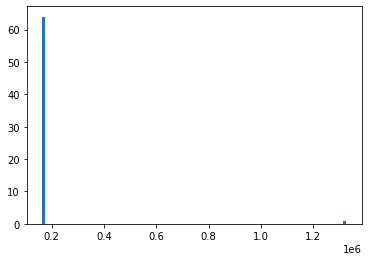

In [59]:
tot_dists = np.array(tot_dists)
plt.hist(tot_dists , bins=100)

In [60]:
np.min(tot_dist)

1326231.7037036524

In [61]:
tot_dists

array([ 163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,  163115.1644599 ,  163115.1644599 ,
        163115.1644599 ,